# Домашнее задание 2. Single-cell

# Загрузка библиотек и данных

In [15]:
library(Seurat)
packageVersion("Seurat")


[1] ‘5.3.1’

In [33]:
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")

In [35]:
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}
library(dplyr)

In [50]:
library(ggplot2)

In [70]:
data_dir <- "/projects/mipt_dbmp_biotechnology/single_cell/H068_sample_filtered_feature_bc_matrix"
pbmc.data <- Read10X(data.dir = data_dir)

print(str(pbmc.data))

10X data contains more than one type and is being returned as a list containing matrices of each type.



List of 2
 $ Gene Expression :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:17128537] 30 45 82 86 113 170 234 238 265 271 ...
  .. ..@ p       : int [1:9235] 0 1577 4776 6891 7227 7793 8781 10818 14232 15904 ...
  .. ..@ Dim     : int [1:2] 36601 9234
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:36601] "MIR1302-2HG" "FAM138A" "OR4F5" "AL627309.1" ...
  .. .. ..$ : chr [1:9234] "AAACCTGAGATGTCGG-1" "AAACCTGAGCAACGGT-1" "AAACCTGAGCTCAACT-1" "AAACCTGAGGGCATGT-1" ...
  .. ..@ x       : num [1:17128537] 4 1 1 1 1 8 1 1 1 1 ...
  .. ..@ factors : list()
 $ Antibody Capture:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:259122] 0 1 5 6 7 8 9 10 11 12 ...
  .. ..@ p       : int [1:9235] 0 30 63 93 121 149 185 214 249 273 ...
  .. ..@ Dim     : int [1:2] 39 9234
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:39] "Hu.CD154" "Hu.CD4_SK3" "Hu.CD8" "Hu.CD56" ...
  .. .. ..$ : chr [1:9234] "AAACCTGAGATGTCGG-1" "AAACCTGAGC

Видим две матрицы:

"Gene Expression" и "Antibody Capture" — это данные CITE-seq (белковые метки), которые не нужны в этой задаче.

In [72]:
library(Seurat)
set.seed(42)

pbmc <- CreateSeuratObject(counts = pbmc.data$`Gene Expression`, project = "H068_PBMC")
# Проверяем размер данных
print(paste("Количество клеток:", ncol(pbmc)))
print(paste("Количество генов:", nrow(pbmc)))

[1] "Количество клеток: 9234"
[1] "Количество генов: 36601"


CellRanger фильтрует "плохие" клетки на основе автоматического анализа распределения количества обнаруженных генов и молекул РНК на клетку, а также процента митохондриальных транскриптов, исключая клетки с аномально низким или высоким содержанием РНК и клетки с признаками апоптоза.

При создании Seurat-объекта с параметрами min.cells = 3 и min.features = 200 фильтруются гены, экспрессирующиеся менее чем в 3 клетках, и клетки, содержащие менее 200 обнаруженных генов, при этом в вашем наборе данных после этой фильтрации остается 8313 клеток и 36601 ген. Однако в моём примере я фильтрую вручную как в туториале на сайте.

# Анализ

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


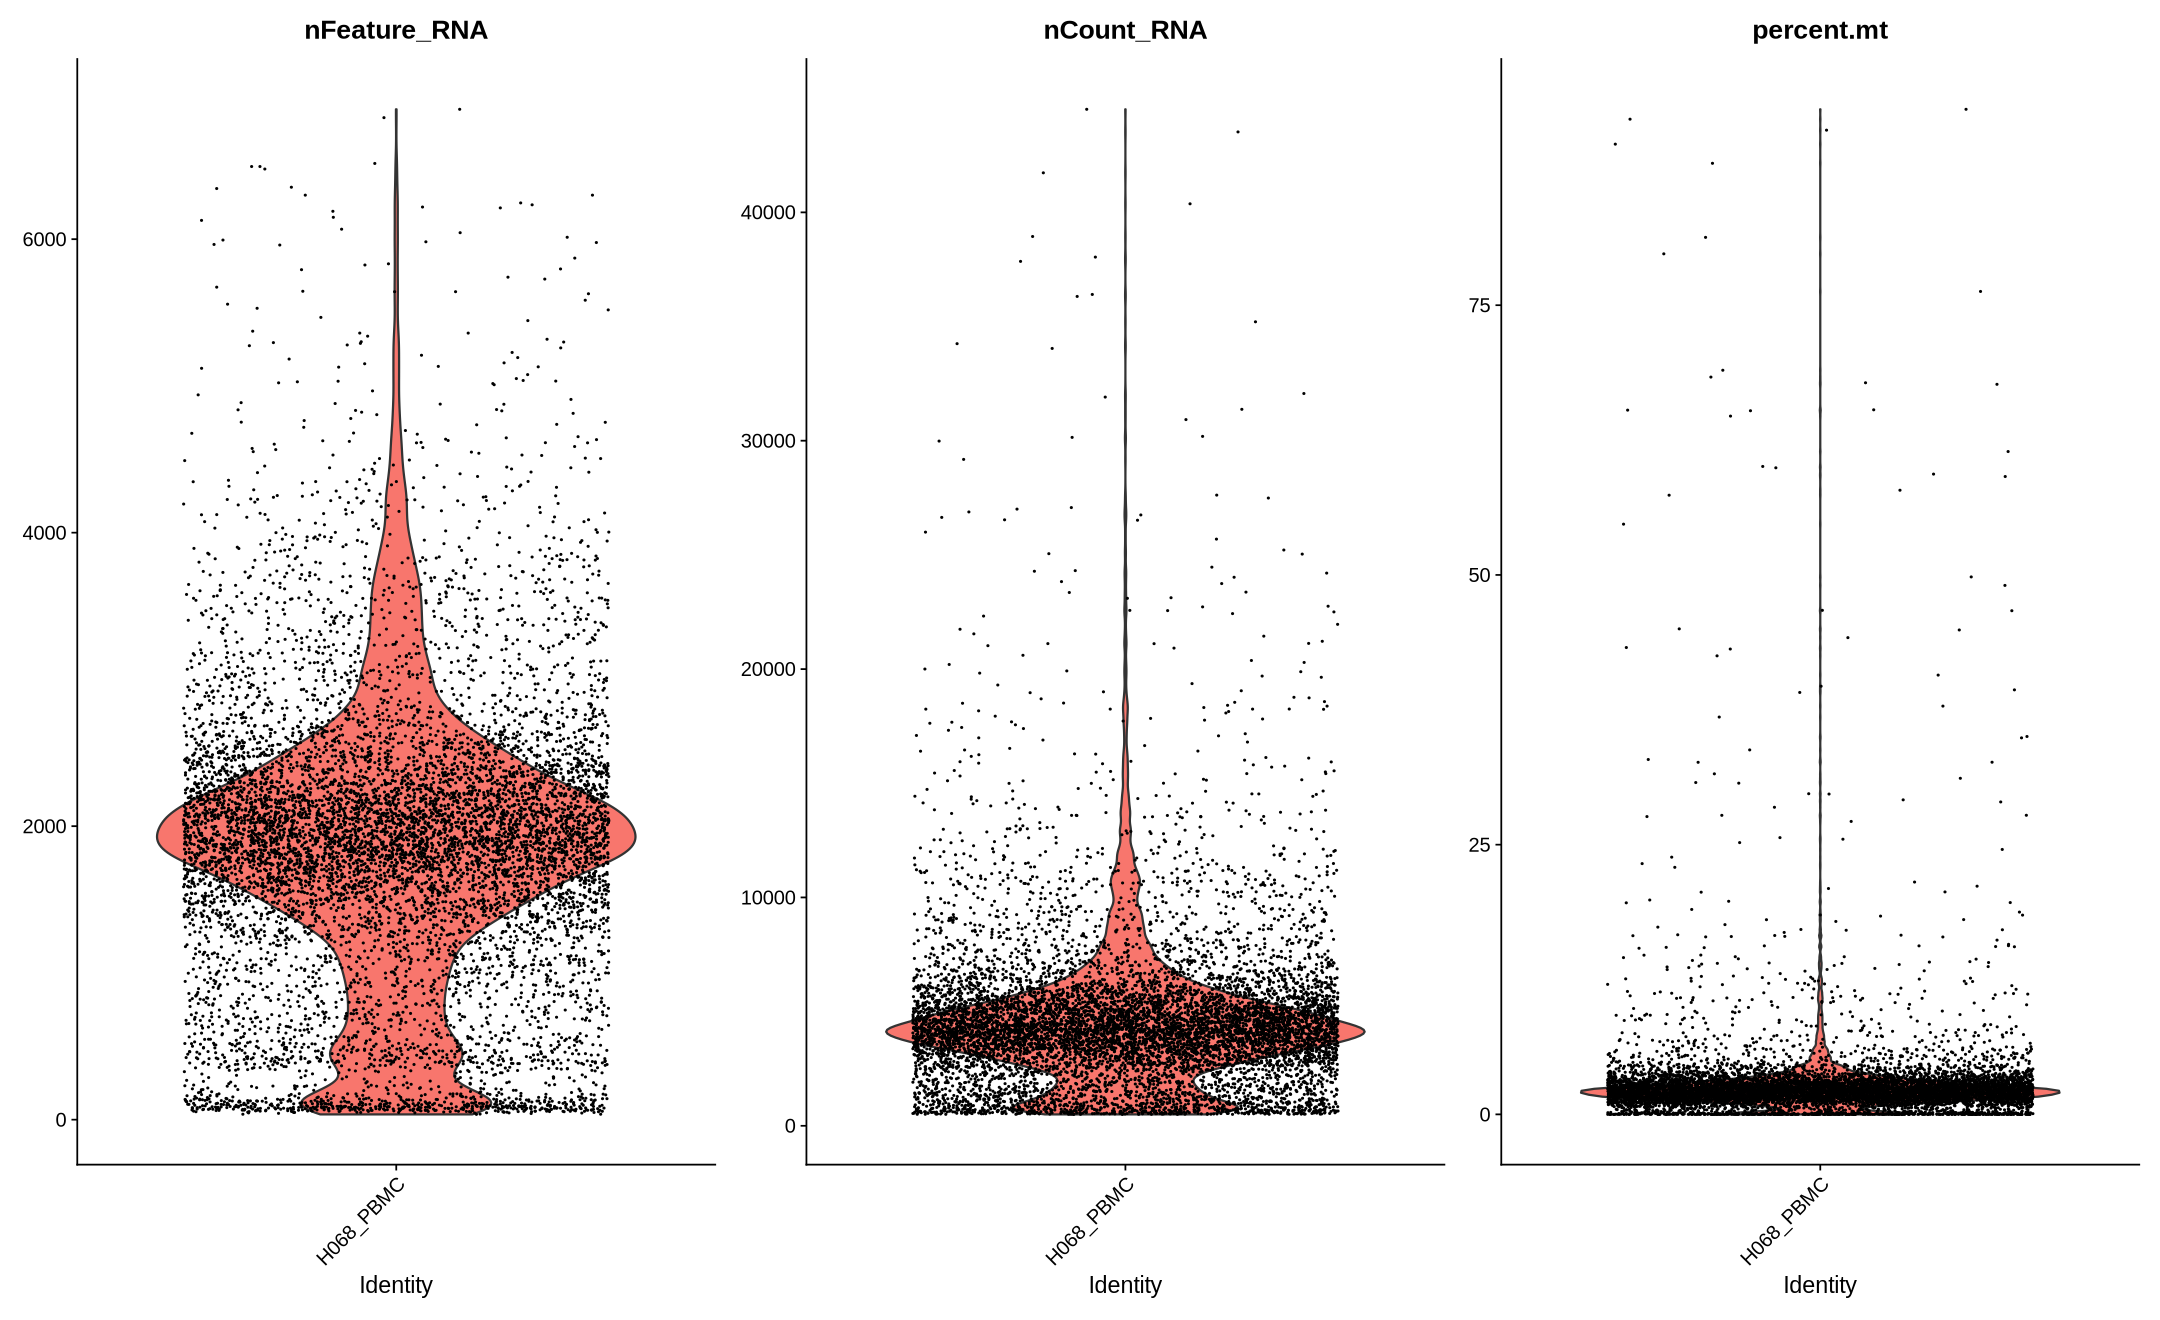

In [73]:
# QC метрики
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# распределения
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

nFeature_RNA — количество генов, экспрессированных в каждой клетке;

nCount_RNA — общее число считанных транскриптов на клетку;

percent.mt — доля митохондриальных генов.

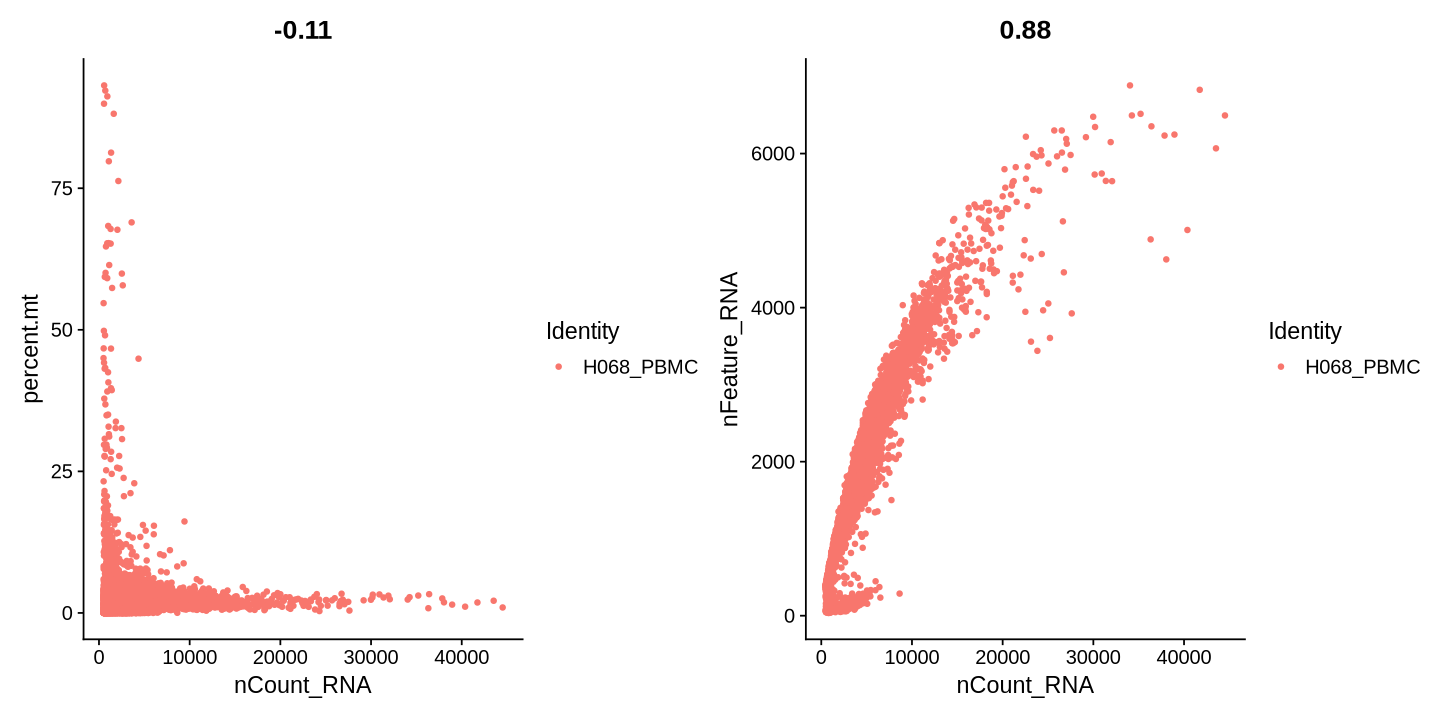

In [74]:
options(repr.plot.width = 12, repr.plot.height = 6)

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

plot1 + plot2

In [77]:
# фильтрация клеток
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 4500 & percent.mt < 10)

In [78]:
# Проверяем размер данных
print(paste("Количество клеток:", ncol(pbmc)))
print(paste("Количество генов:", nrow(pbmc)))

[1] "Количество клеток: 8313"
[1] "Количество генов: 36601"


Таким образом можно отфильтровать погибшие клетки, multiplets (несколько клеток в одной капле) и технические артефакты, оставив только качественные клетки для дальнейшего анализа. В нашем случае отбраковалось почти 1000 клеток 

In [79]:
# Нормализация данных
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [80]:
# Выявление высоковарьирующих генов
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts



Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


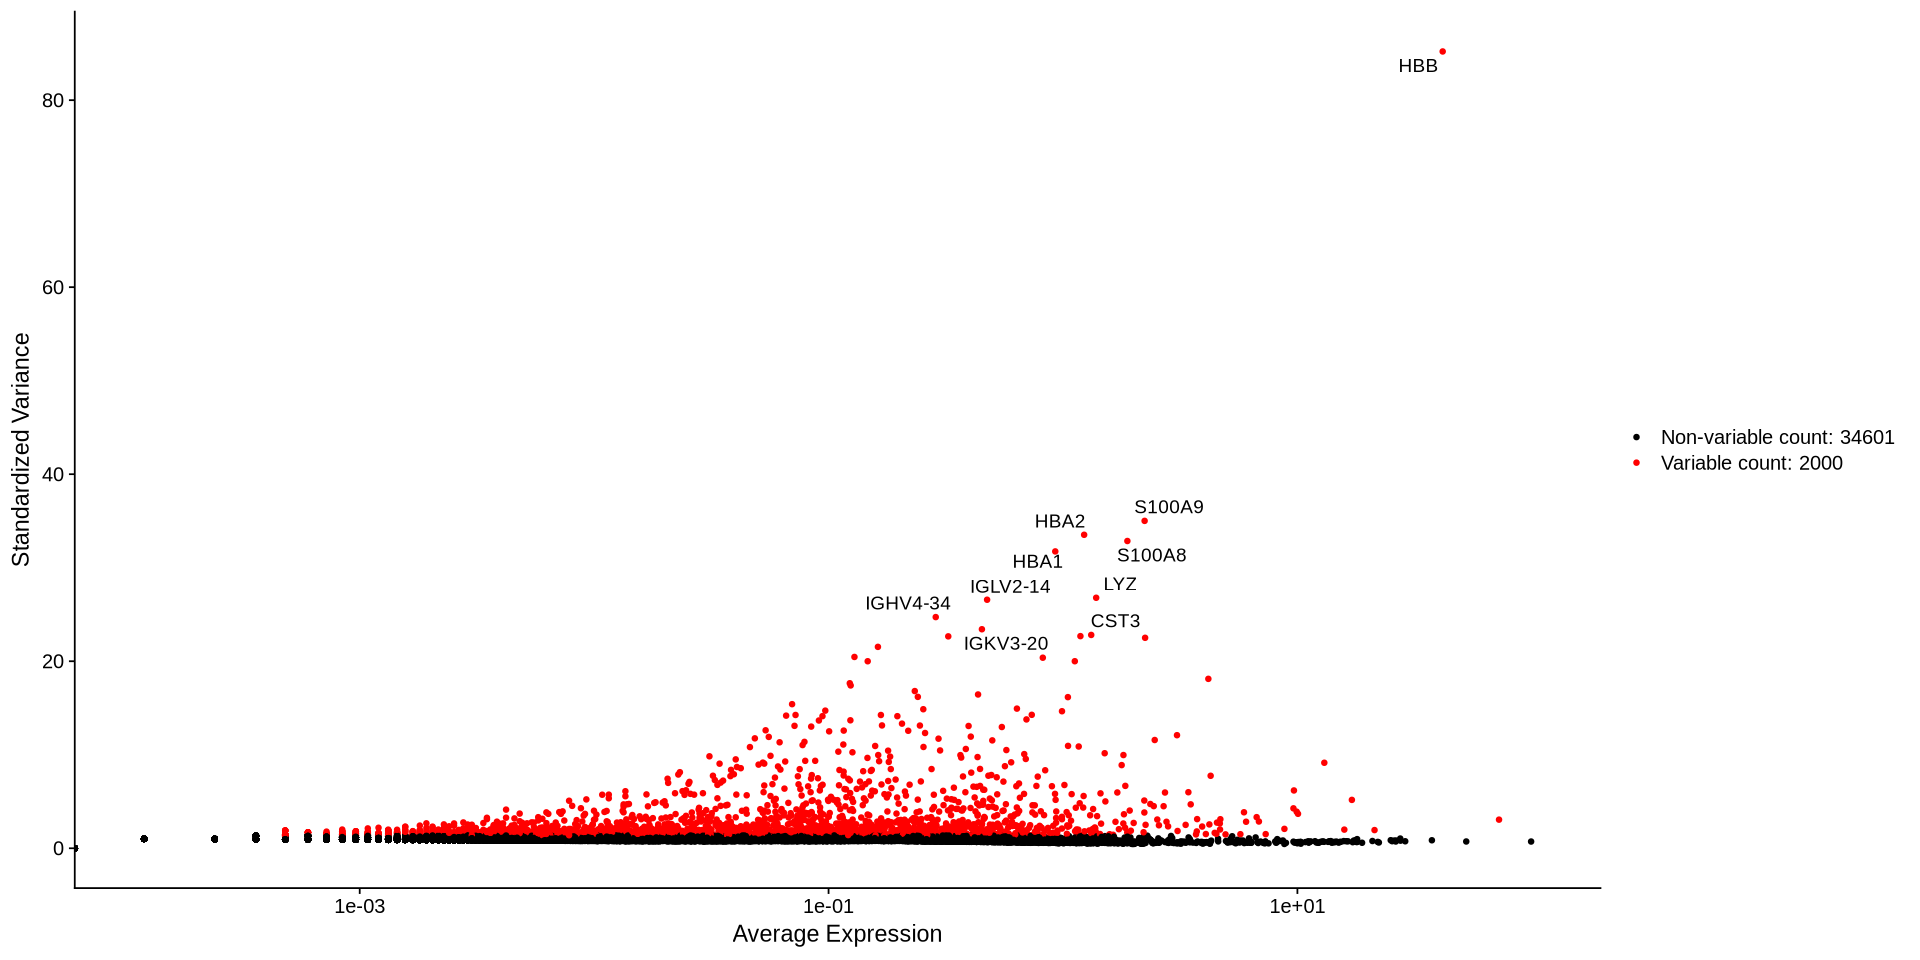

In [81]:
# Визуализация высоковарьирующих генов
top10 <- head(VariableFeatures(pbmc), 10)
options(repr.plot.width = 16, repr.plot.height = 8)
plot1 <- VariableFeaturePlot(pbmc)

plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, 
                    xnudge = 0, ynudge = 0,
                    size = 4)
plot2

Высоковарьирующие гены могут быть маркерными генами, которые отличают разные типы клеток

Гены с высокой экспрессией но низкой вариабельностью часто могут быть генами домашнего хозяйства.

In [82]:
# Масштабирование данных
pbmc <- ScaleData(pbmc)

Centering and scaling data matrix



In [83]:
# Проверяем размер данных
print(paste("Количество клеток:", ncol(pbmc)))
print(paste("Количество генов:", nrow(pbmc)))

[1] "Количество клеток: 8313"
[1] "Количество генов: 36601"


In [84]:
# Линейное снижение размерности (PCA)
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  IL32, CXCR4, IL7R, LTB, ACTB, LEF1, ACTG1, CD69, CCR7, CTSW 
	   CD27, SSR4, PPIB, INPP4B, TRBC1, BACH2, NKG7, CST7, PASK, GZMA 
	   SLC2A3, KLRB1, GAPDH, KLRG1, PRF1, ICOS, ZNF331, FKBP11, FAAH2, AQP3 
Negative:  IL1B, TNFAIP2, HCK, DMXL2, KYNU, IRAK3, AQP9, PLAUR, SLC8A1, ACSL1 
	   NLRP3, RBM47, DENND5A, LRMDA, PLXDC2, VCAN, PILRA, FAM49A, IFNGR2, TLR2 
	   ICAM1, SOD2, FCN1, RNF19B, RNF144B, ABCA1, SPI1, TCF7L2, AZIN1-AS1, IRAK2 
PC_ 2 
Positive:  IL32, SRGN, TNFAIP3, S100A4, NKG7, CST7, CTSW, CCL5, PRF1, S100A6 
	   GZMA, ANXA1, AOAH, KLRB1, KLRD1, DUSP2, GZMB, MT2A, GNLY, S100A10 
	   KLRG1, IL7R, S1PR5, CCL4, FGFBP2, GZMH, IL2RB, HOPX, CX3CR1, SPON2 
Negative:  MS4A1, CD79A, BANK1, FCRL1, HLA-DQA1, HLA-DRA, AFF3, HLA-DQB1, NIBAN3, IGHM 
	   HLA-DRB1, TCL1A, HLA-DQA2, PAX5, RALGPS2, PLEKHG1, LINC00926, EBF1, MEF2C, CD79B 
	   HLA-DPA1, TCF4, CD19, GNG7, FCRLA, SPIB, RUBCNL, CCSER1, CD74, HLA-DMA 
PC_ 3 
Positive:  IER2, NKG7, ZFP36, CST7, DUSP2, JUNB, CD69, NFKB

PC_ 1 
Positive:  IL32, CXCR4, IL7R, LTB, ACTB 
Negative:  IL1B, TNFAIP2, HCK, DMXL2, KYNU 
PC_ 2 
Positive:  IL32, SRGN, TNFAIP3, S100A4, NKG7 
Negative:  MS4A1, CD79A, BANK1, FCRL1, HLA-DQA1 
PC_ 3 
Positive:  IER2, NKG7, ZFP36, CST7, DUSP2 
Negative:  TUBB1, CAVIN2, ACRBP, PRKAR2B, PF4 
PC_ 4 
Positive:  LEF1, CCR7, MAML2, LTB, PRKCA 
Negative:  TYROBP, NKG7, CCL5, ACTB, CST7 
PC_ 5 
Positive:  AIF1, LYZ, MNDA, FGL2, CFD 
Negative:  CCL5, NKG7, PRF1, CST7, GZMB 


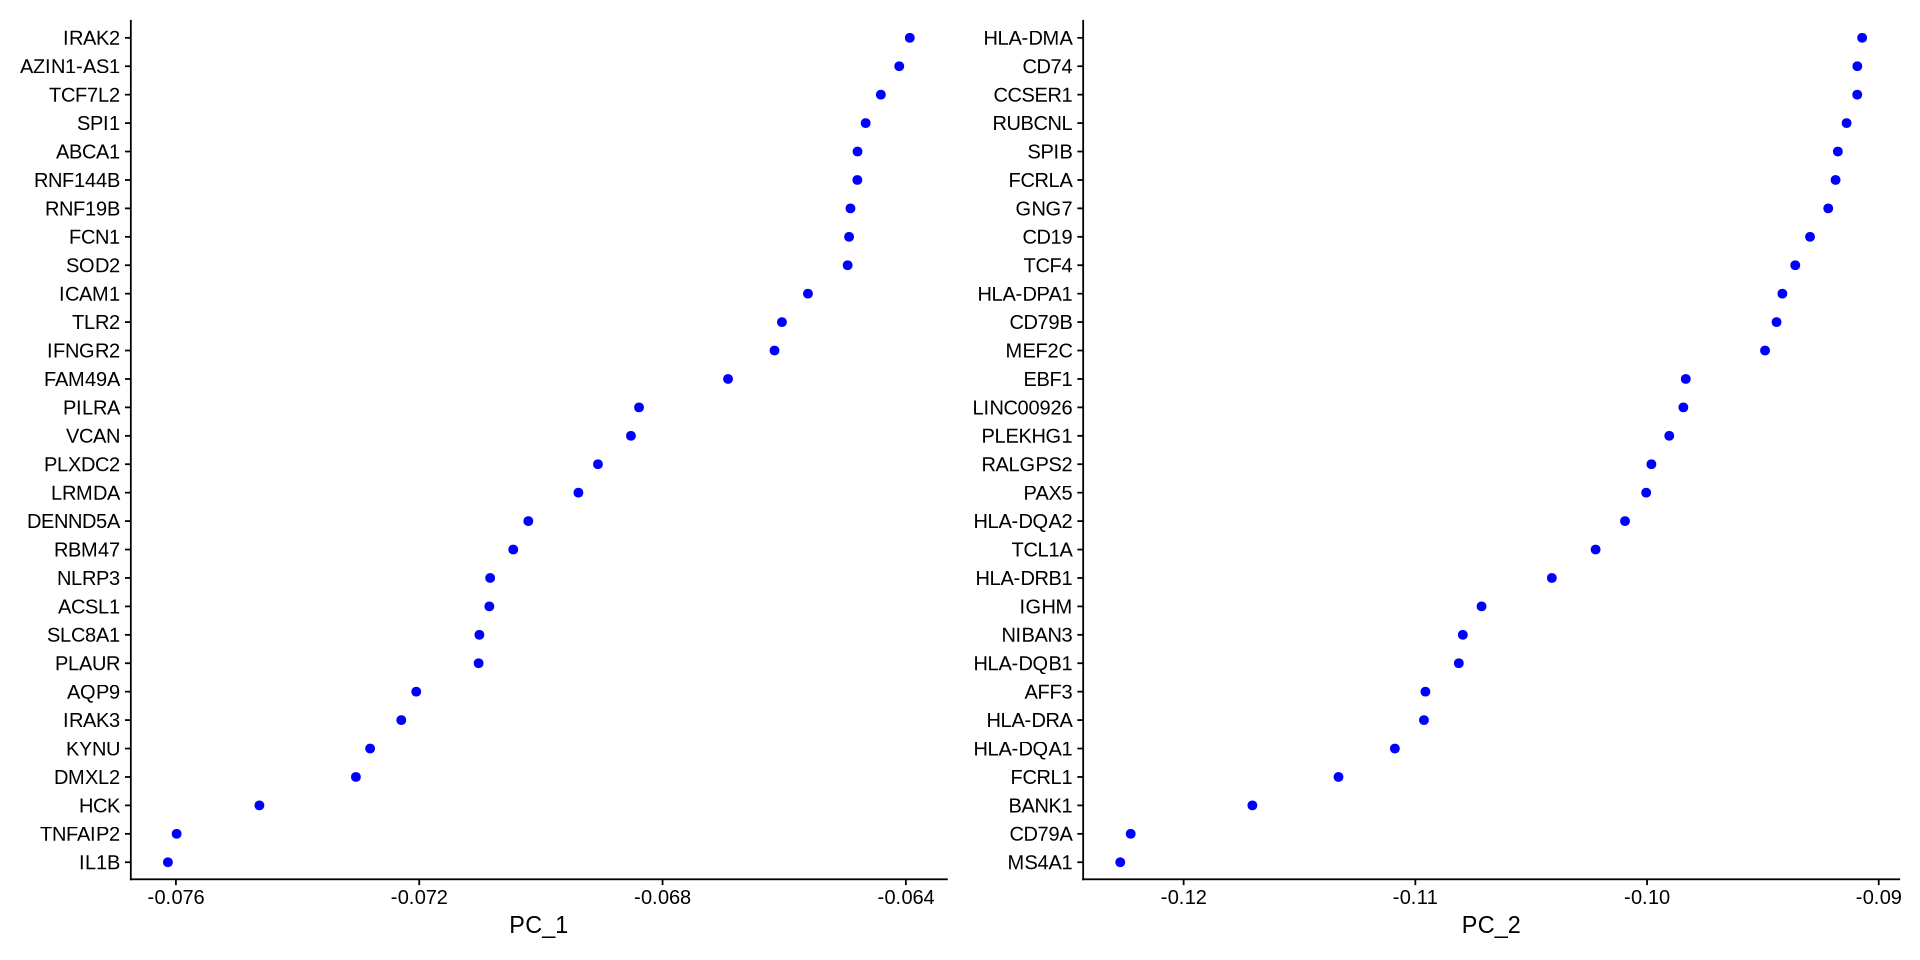

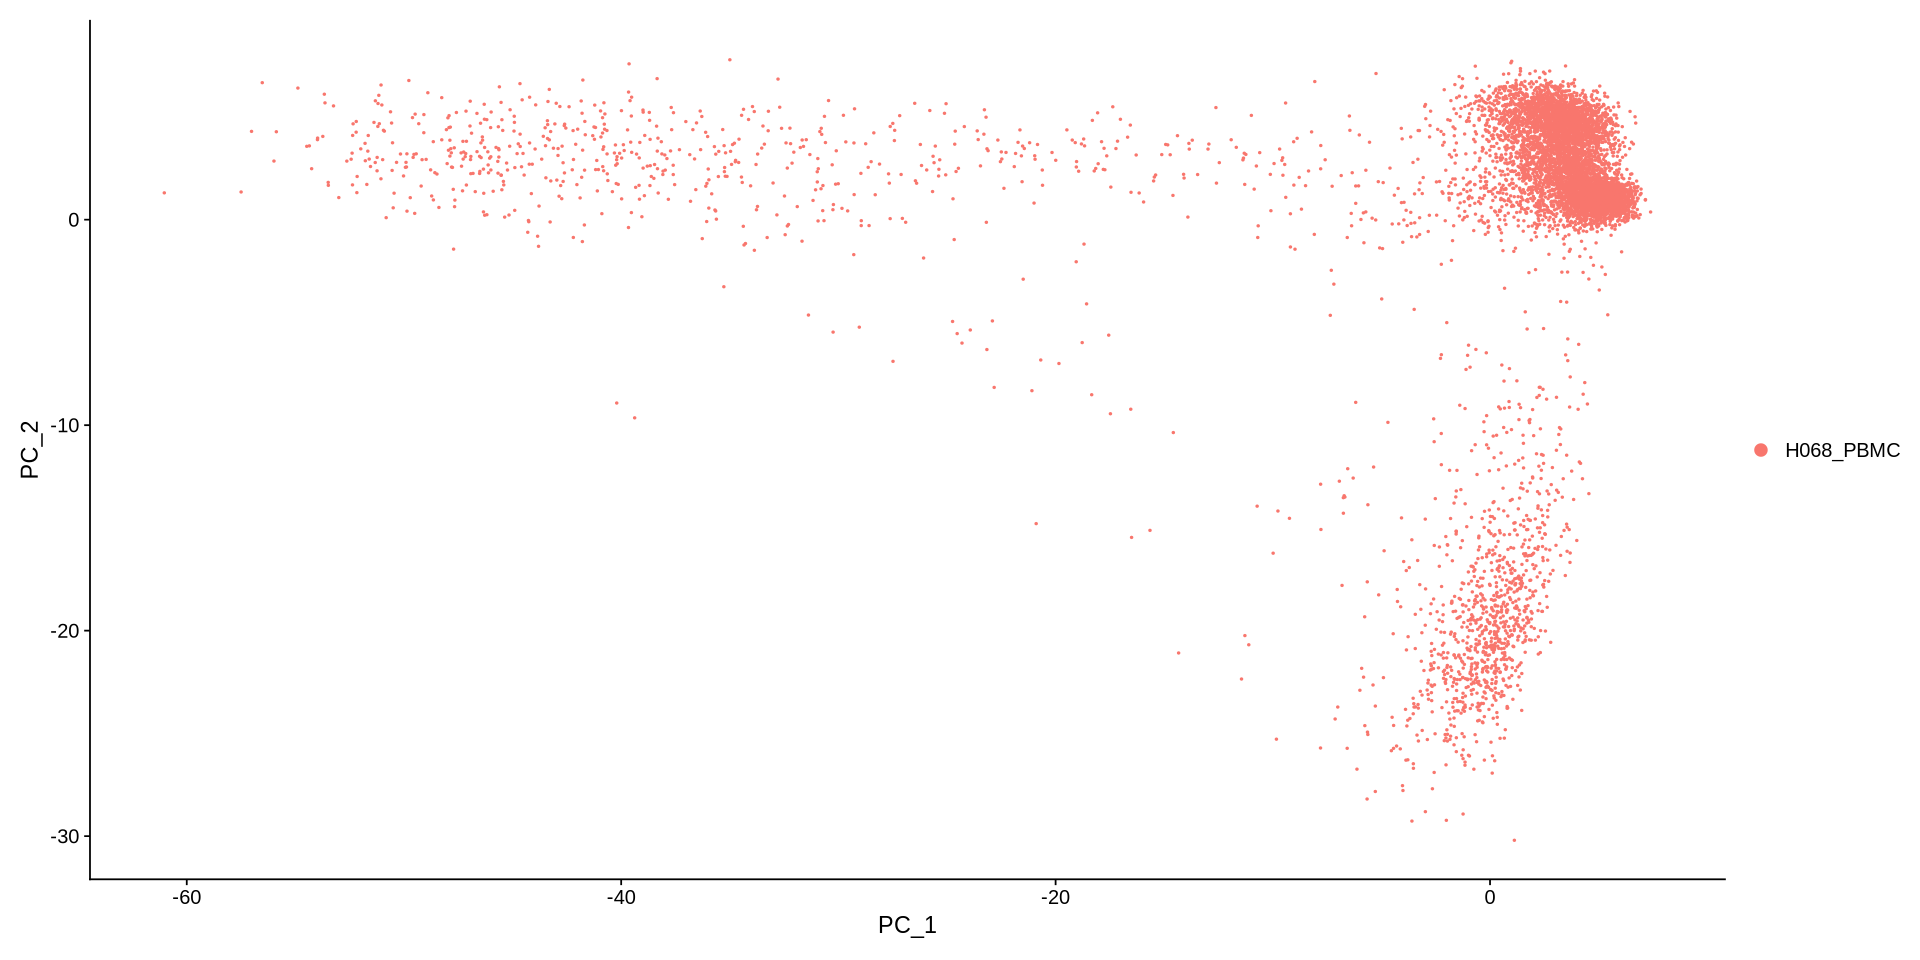

In [85]:
# Визуализация PCA
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")
DimPlot(pbmc, reduction = "pca")

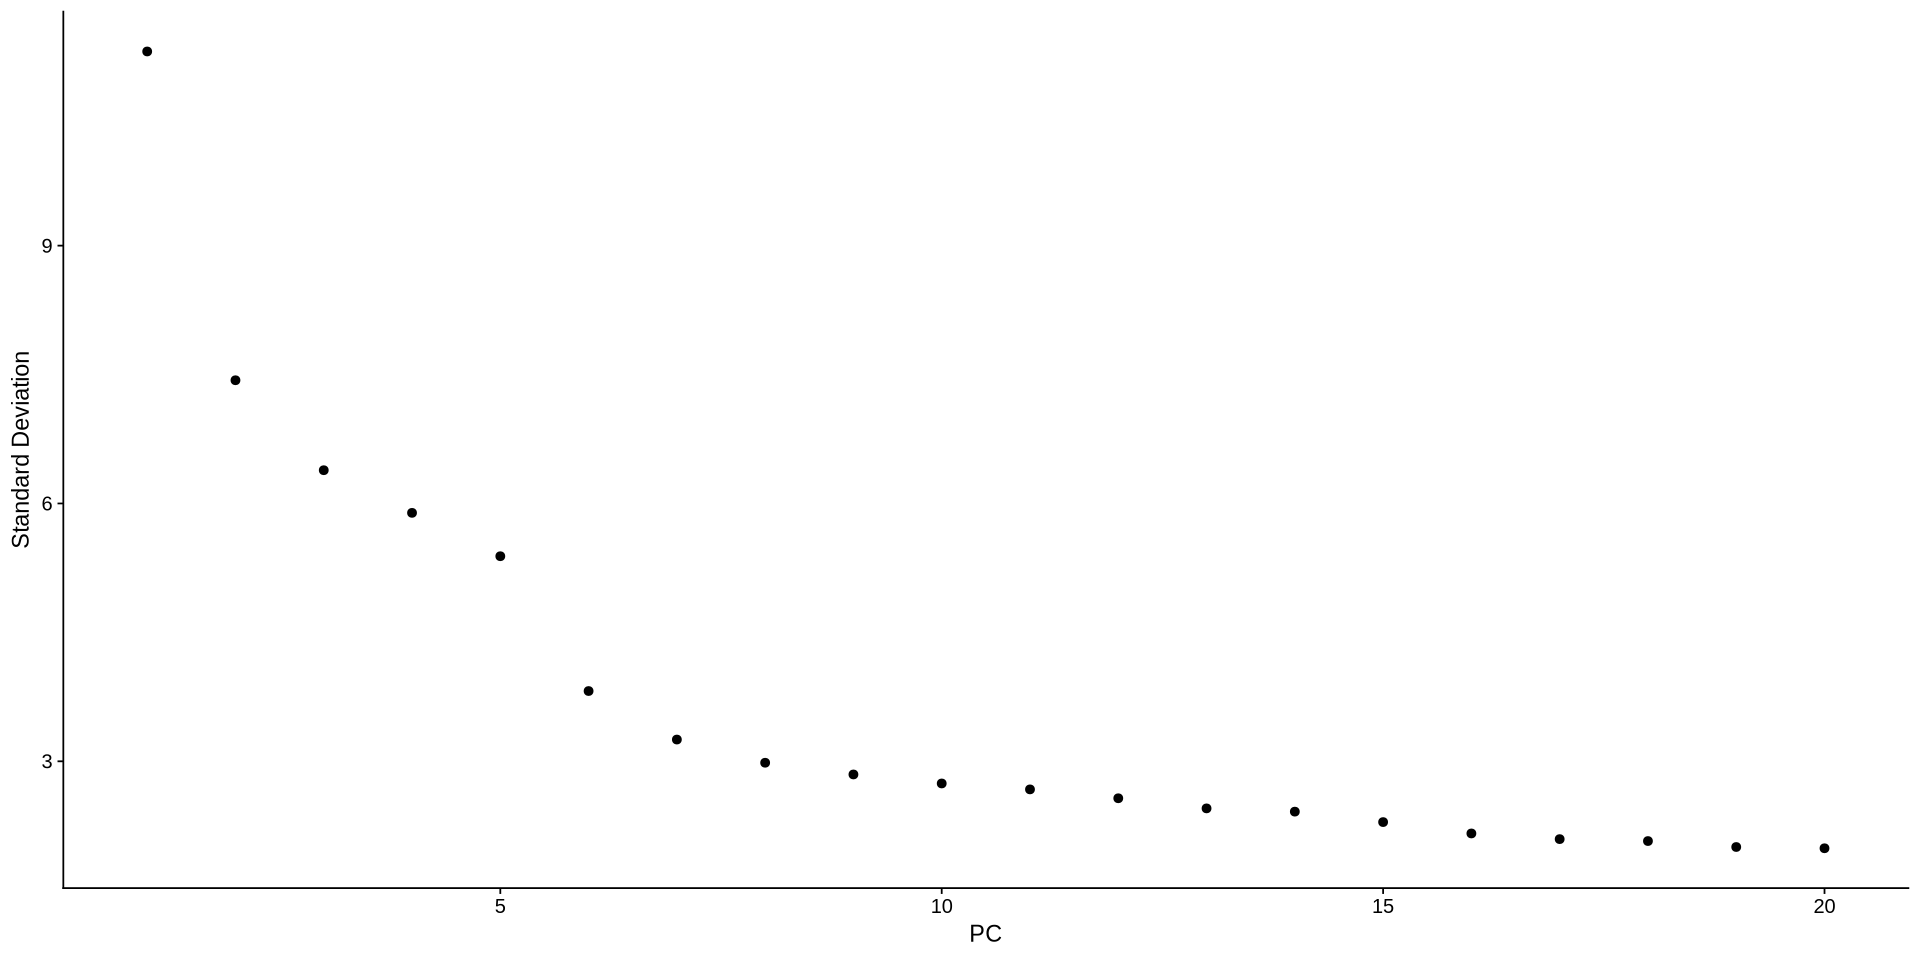

In [86]:
# Определение значимых компонент
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)
ElbowPlot(pbmc)

Достаточно взять первые 10 компонент, так как дальше график выходит на плато, то есть первые 10 компонент объясняют значительную долю дисперсии

In [87]:
# Кластеризация клеток
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8313
Number of edges: 266381

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9100
Number of communities: 14
Elapsed time: 0 seconds


19:43:51 UMAP embedding parameters a = 0.9922 b = 1.112

19:43:51 Read 8313 rows and found 10 numeric columns

19:43:51 Using Annoy for neighbor search, n_neighbors = 30

19:43:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:43:52 Writing NN index file to temp file /scratch/RtmpPtc0GW/file2d54c81f4a79e1

19:43:52 Searching Annoy index using 1 thread, search_k = 3000

19:43:55 Annoy recall = 100%

19:43:55 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

19:43:56 Initializing from normalized Laplacian + noise (using RSpectra)

19:43:56 Commencing optimization for 500 epochs, with 342260 positive edges

19:43:56 Using rng type: pcg

19:44:08 Optimization finished



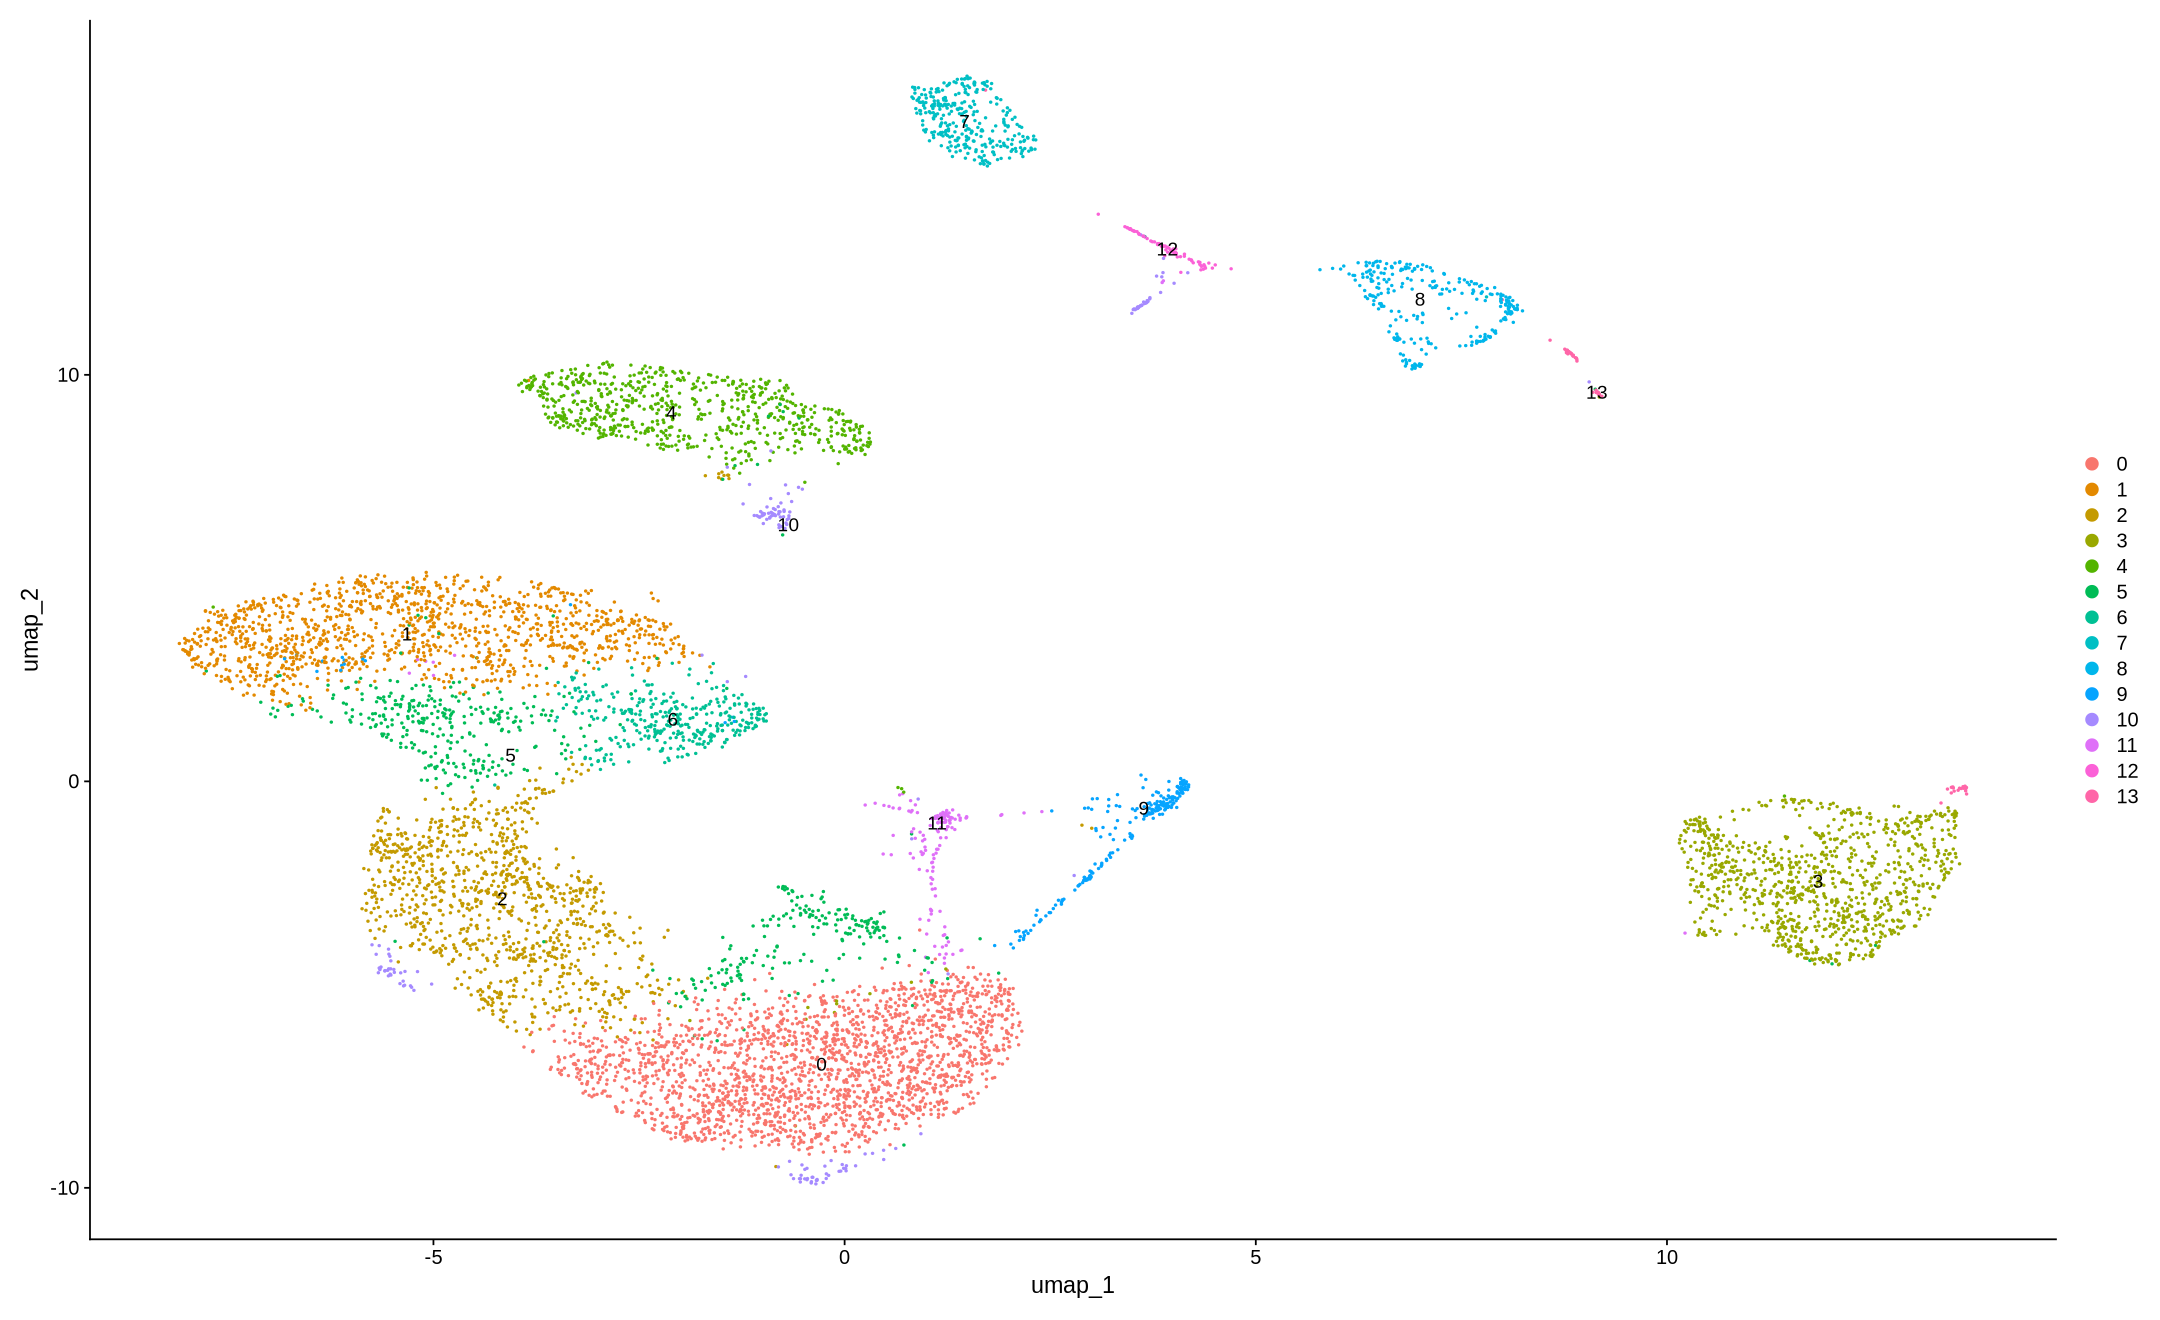

In [97]:
# Нелинейное снижение размерности (UMAP)
pbmc <- RunUMAP(pbmc, dims = 1:10)

# Визуализация UMAP с кластерами
options(repr.plot.width = 18, repr.plot.height = 11)
DimPlot(pbmc, reduction = "umap", label = TRUE)

и пару UMAP с другими параметрами:

19:43:09 UMAP embedding parameters a = 0.9922 b = 1.112

19:43:09 Read 8313 rows and found 10 numeric columns

19:43:09 Using Annoy for neighbor search, n_neighbors = 2

19:43:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:43:10 Writing NN index file to temp file /scratch/RtmpPtc0GW/file2d54c831b2f9d3

19:43:10 Searching Annoy index using 1 thread, search_k = 200

19:43:10 Annoy recall = 100%

19:43:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 2

19:43:11 Found 1725 connected components, 
falling back to 'spca' initialization with init_sdev = 1

19:43:11 Using 'irlba' for PCA

19:43:11 PCA: 2 components explained 54.14% variance

19:43:11 Scaling init to sdev = 1

19:43:11 Commencing optimization for 500 epochs, with 13

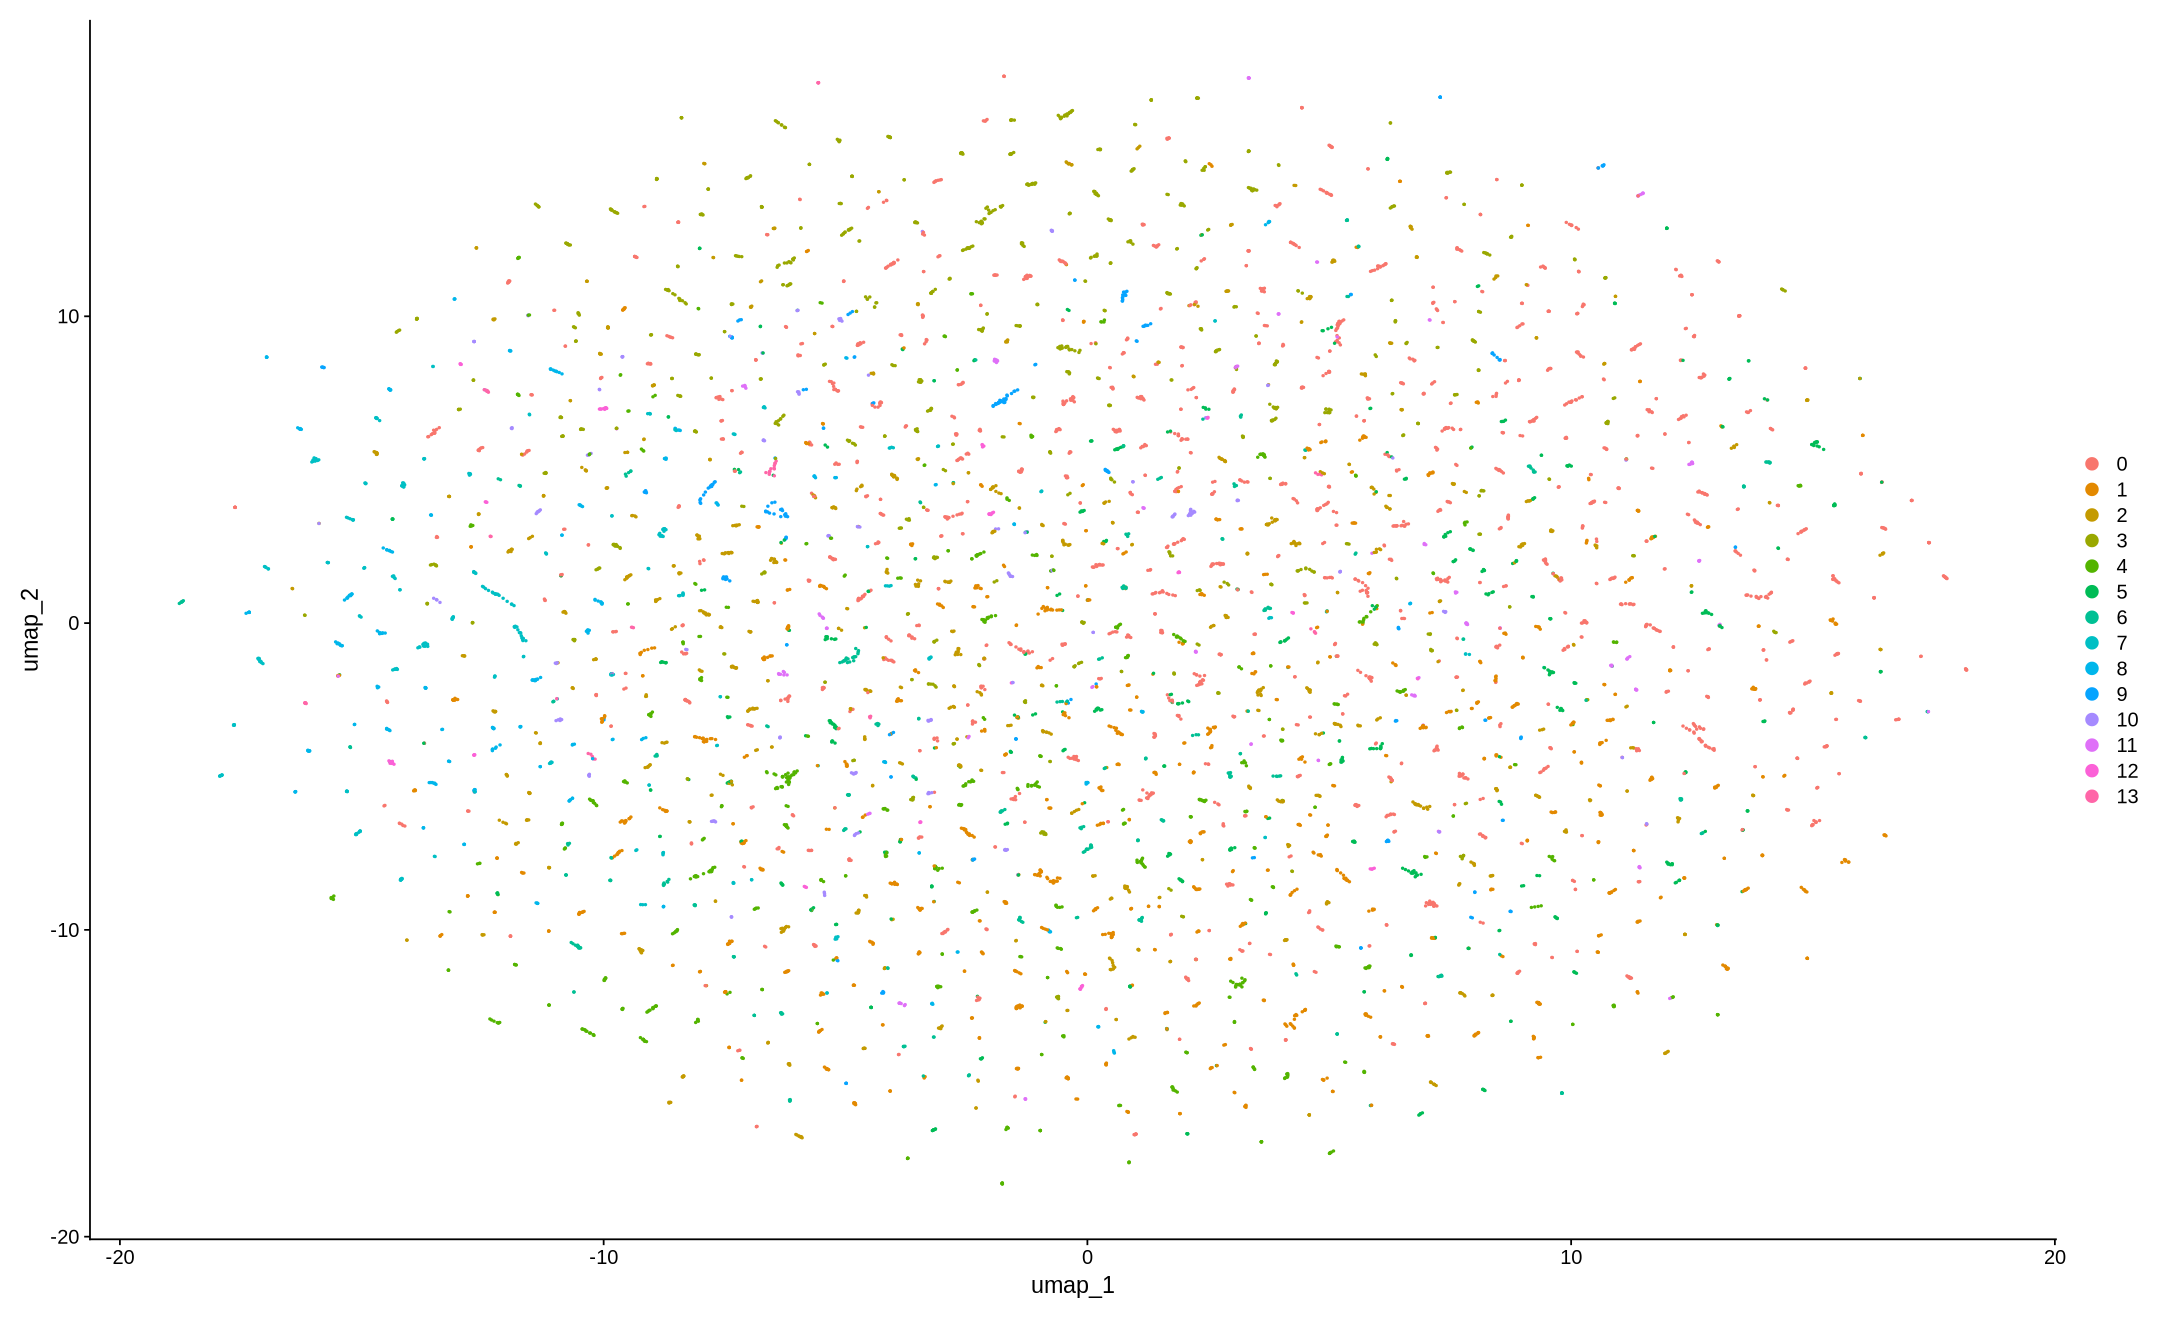

In [95]:
GEX.so <- RunUMAP(pbmc, dims = 1:10, n.neighbors = 2) 
options(repr.plot.width = 18, repr.plot.height = 11)
DimPlot(GEX.so, reduction = "umap")

UMAP выше учитывает очень маленькое число соседей

19:43:19 UMAP embedding parameters a = 0.9922 b = 1.112

19:43:19 Read 8313 rows and found 50 numeric columns

19:43:19 Using Annoy for neighbor search, n_neighbors = 20

19:43:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:43:20 Writing NN index file to temp file /scratch/RtmpPtc0GW/file2d54c83cfd1a0a

19:43:20 Searching Annoy index using 1 thread, search_k = 2000

19:43:22 Annoy recall = 100%

19:43:22 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

19:43:23 Initializing from normalized Laplacian + noise (using RSpectra)

19:43:23 Commencing optimization for 500 epochs, with 241706 positive edges

19:43:23 Using rng type: pcg

19:43:34 Optimization finished



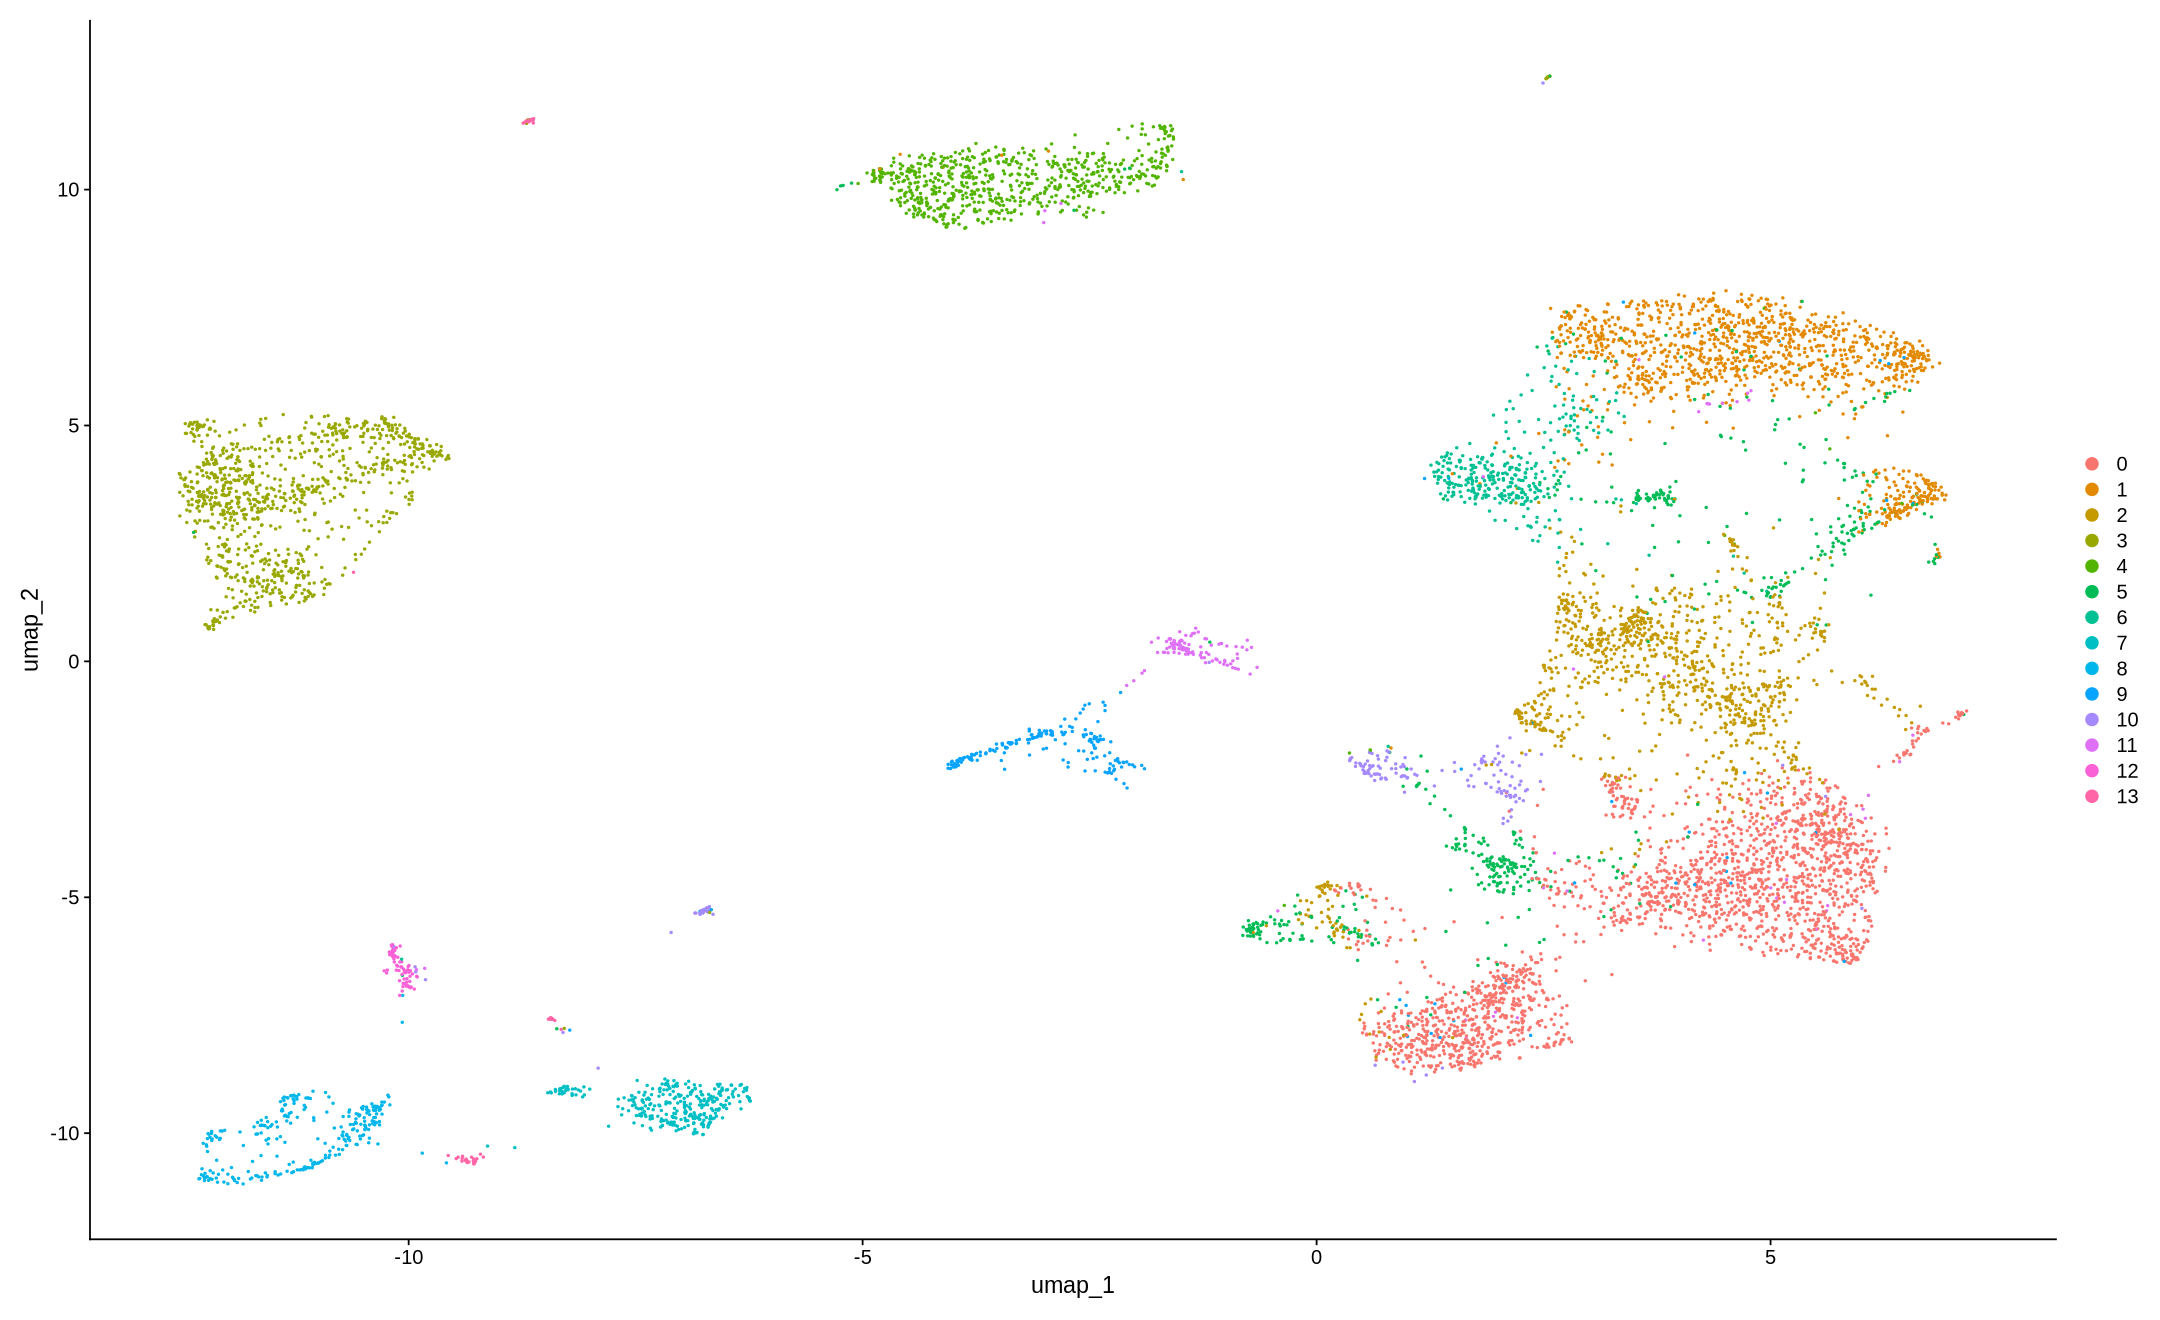

In [96]:
GEX.so <- RunUMAP(pbmc, dims = 1:50, n.neighbors = 20) 
options(repr.plot.width = 18, repr.plot.height = 11)
DimPlot(GEX.so, reduction = "umap")


Здесь больше соседей, но и больше главных компонент. Дальше буду использовать первый вариант UMAP.

In [98]:
# Поиск маркерных генов для кластеров
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



In [99]:
# Топ маркеров для каждого кластера
top_markers <- pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 5, order_by = avg_log2FC)

print("Топ маркерные гены для каждого кластера:")
print(top_markers)

[1] "Топ маркерные гены для каждого кластера:"
# A tibble: 70 × 7
# Groups:   cluster [14]
       p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene    
       <dbl>      <dbl> <dbl> <dbl>     <dbl> <fct>   <chr>   
 1 1.08e-275       3.20 0.321 0.042 3.96e-271 0       ADTRP   
 2 2.07e-312       3.09 0.38  0.057 7.56e-308 0       LEF1-AS1
 3 0               3.05 0.434 0.064 0         0       NELL2   
 4 0               2.95 0.538 0.096 0         0       TRABD2A 
 5 0               2.85 0.559 0.098 0         0       MAL     
 6 0               4.80 0.824 0.042 0         1       TRDV2   
 7 0               4.36 0.803 0.067 0         1       TRGV9   
 8 9.44e-274       3.19 0.345 0.041 3.46e-269 1       ZNF683  
 9 0               3.09 0.631 0.087 0         1       LAG3    
10 0               3.00 0.715 0.108 0         1       GZMH    
# ℹ 60 more rows


[1] "Доступные маркерные гены:"
 [1] "CD3E"   "IL7R"   "CCR7"   "S100A4" "CD8A"   "GNLY"   "NKG7"   "MS4A1" 
 [9] "CD14"   "LYZ"    "FCGR3A" "MS4A7"  "FCER1A" "CST3"   "PPBP"  


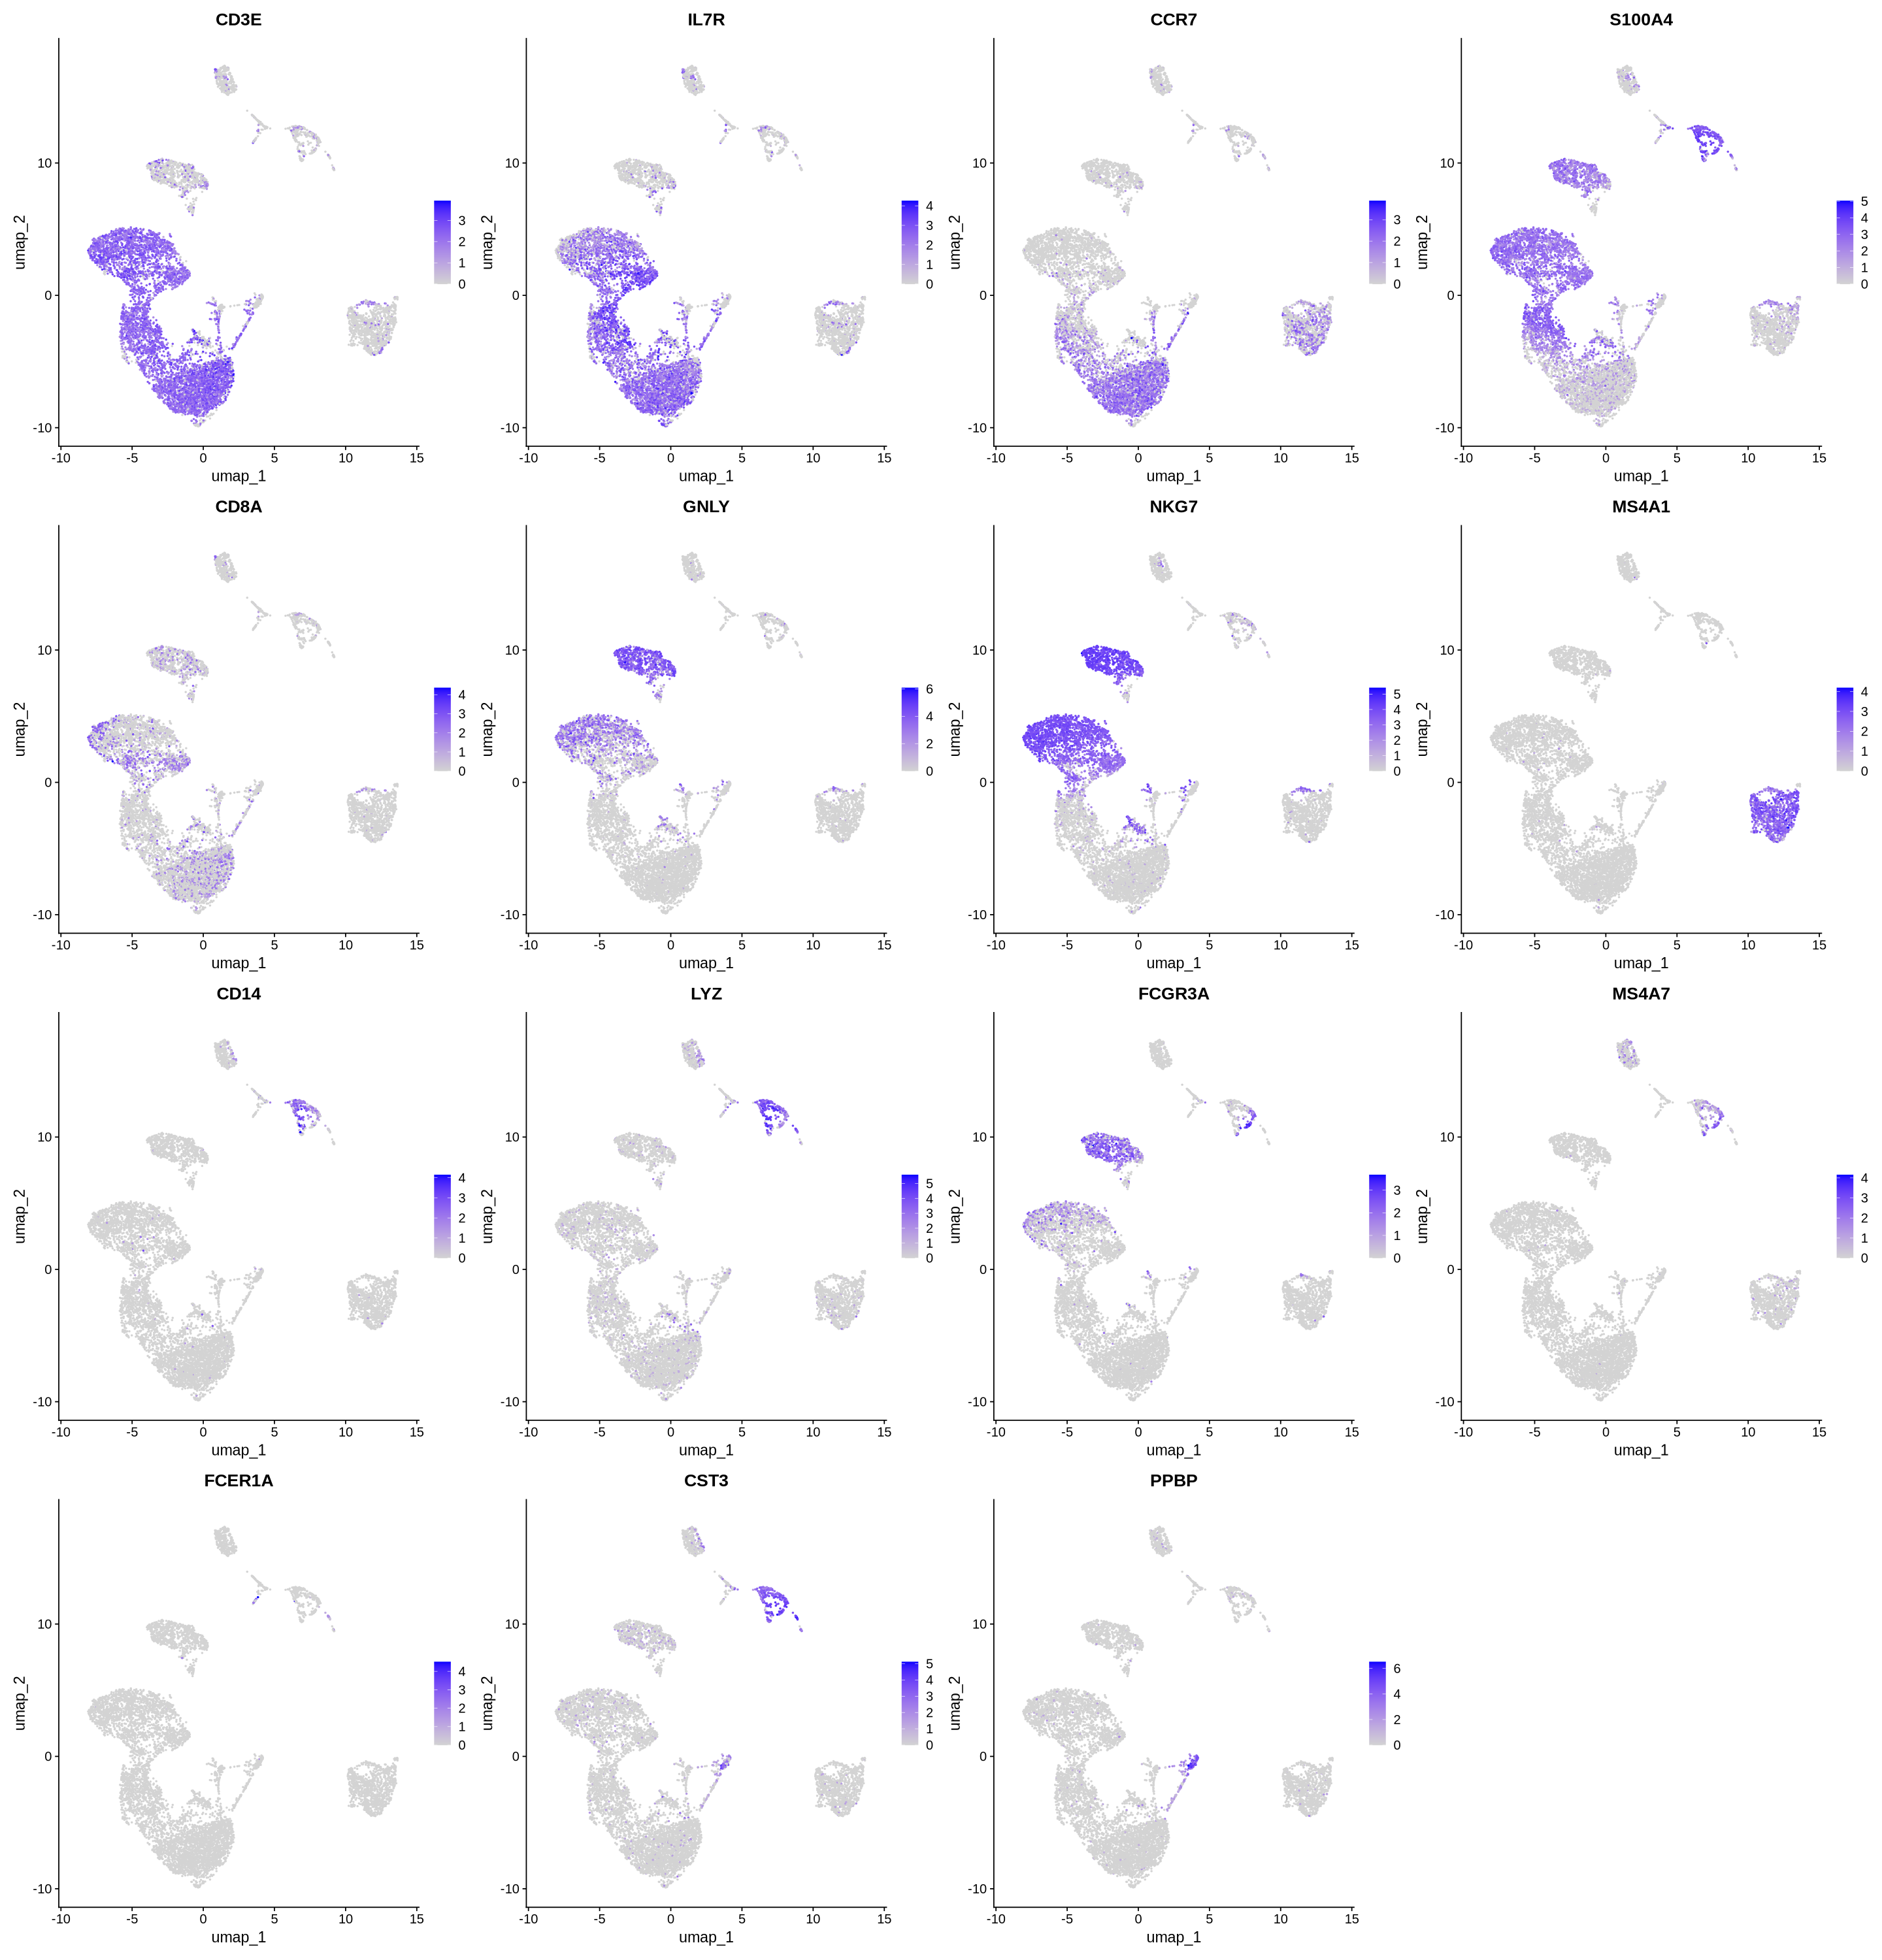

In [100]:
feature_genes <- c(
  # T-клетки
  "CD3E", "IL7R", "CCR7",    # Naive CD4+ T
  "S100A4",                  # Memory CD4+ T  
  "CD8A",                    # CD8+ T
  # NK-клетки
  "GNLY", "NKG7",
  # B-клетки
  "MS4A1",
  # Моноциты
  "CD14", "LYZ",             # CD14+ Mono
  "FCGR3A", "MS4A7",         # FCGR3A+ Mono
  # Дендритные клетки
  "FCER1A", "CST3",
  # Тромбоциты
  "PPBP"
)

# Проверяем, какие гены присутствуют в данных
available_genes <- feature_genes[feature_genes %in% rownames(pbmc)]
print("Доступные маркерные гены:")
print(available_genes)

# Высокий график с 2 столбцами
options(repr.plot.width = 24, repr.plot.height = 25)
FeaturePlot(pbmc, features = available_genes, ncol = 4)

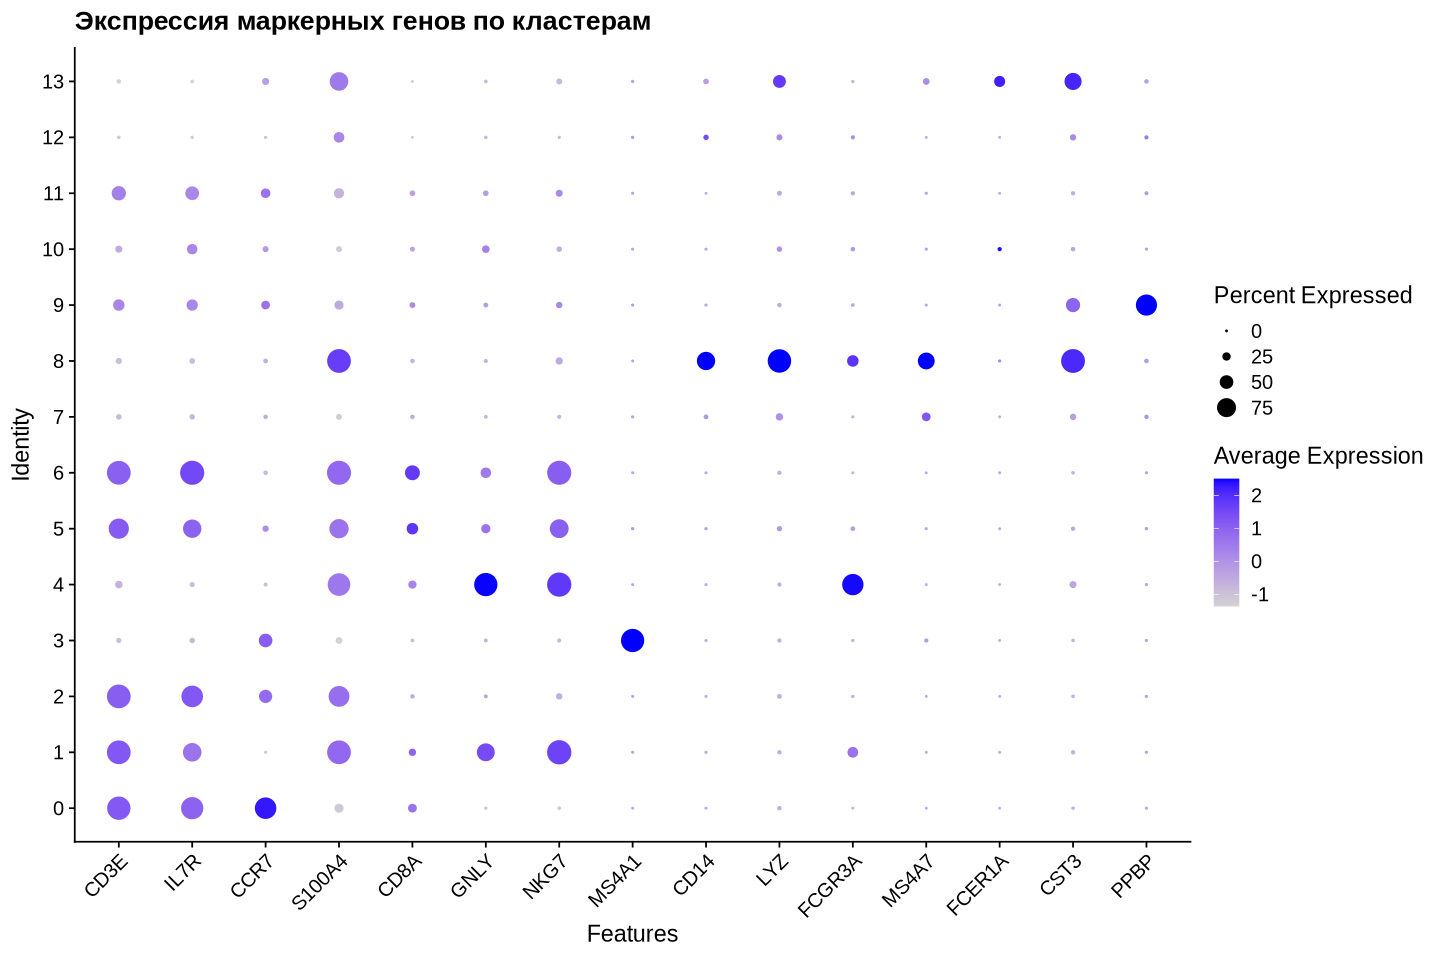

In [51]:
# Создаем DotPlot для визуализации экспрессии маркеров по кластерам
options(repr.plot.width = 12, repr.plot.height = 8)
DotPlot(pbmc, features = available_genes) + 
  RotatedAxis() +
  ggtitle("Экспрессия маркерных генов по кластерам")

По построенным графикам определим:

**Тип клеток (маркер): номер кластера**
- B-клетки (MS4A1): 3
- CD8+ T (CD8A): 5,6
- Naive CD4+ T (IL7R, CCR7): 0
- Memory CD4+ (IL7R, S100A4): 2
- NK (GNLY, NKG7): 4
- CD14+ Mono (CD14, LYZ): 8
- Дендритные клетки (FCER1A, CST3): 13

Кластер 1 оставила неопределённым, потому что здесь есть как экспрессия генов, характерных для NK-клеток, но при этом чётко экспрессируется маркёры T-клеток (CD3E)

[1] "Таблица распределения:"

   Naive CD4+ T         Unknown   Memory CD4+ T         B cells        NK cells 
           2145            2174            1075             993             708 
         CD8+ T      CD14+ Mono Dendritic cells 
            893             269              56 


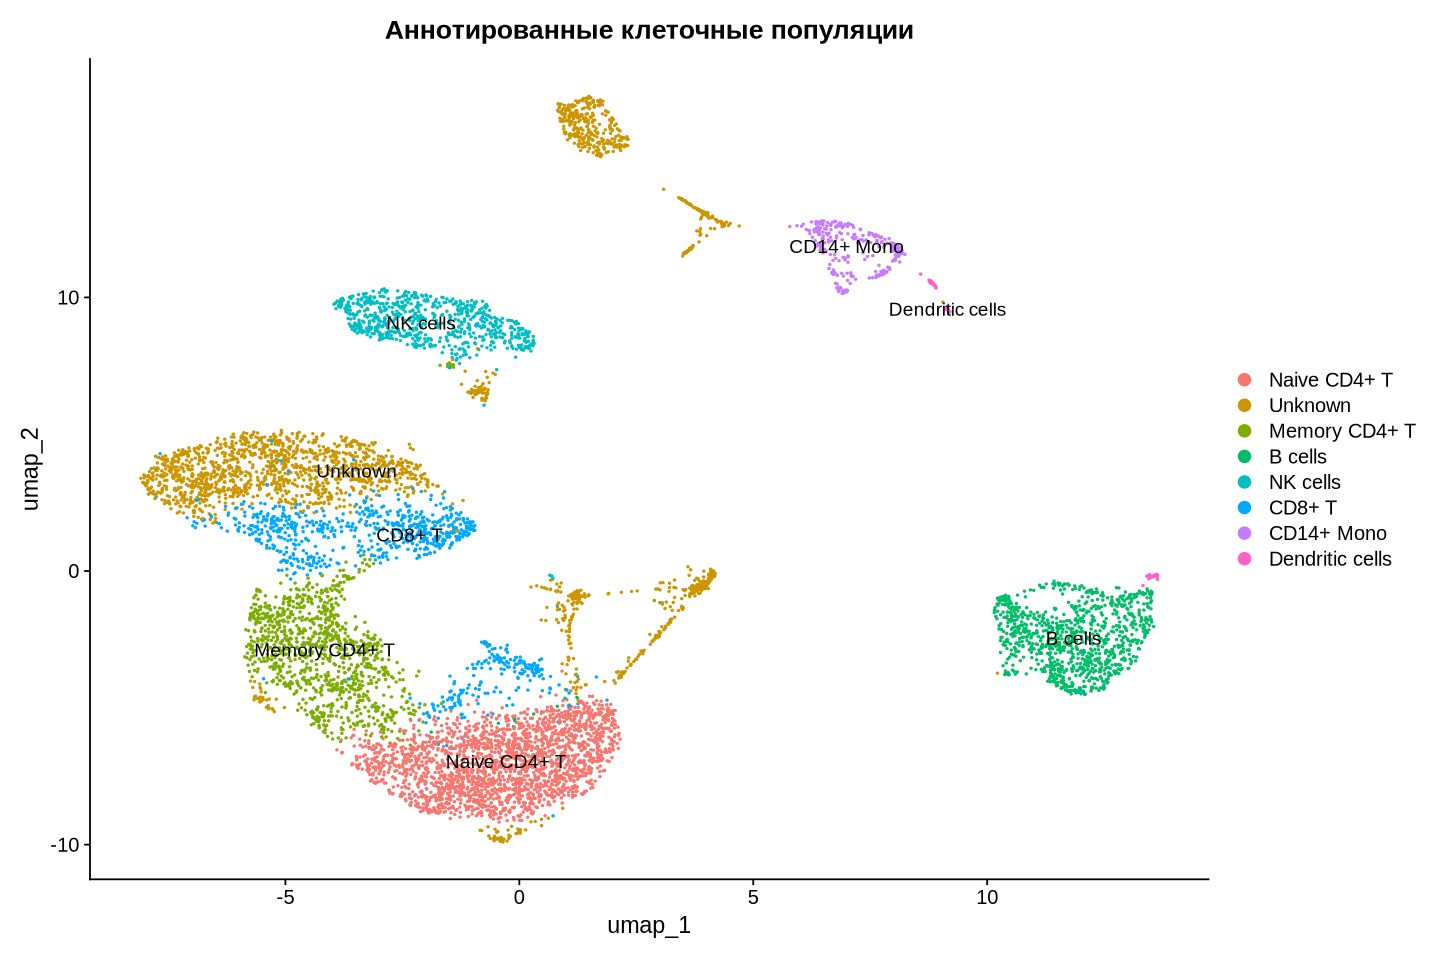

In [62]:
# Создаем факторную переменную для аннотаций
cell_type_factor <- factor(pbmc$seurat_clusters, 
                          levels = c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13"),
                          labels = c("Naive CD4+ T", "Unknown", "Memory CD4+ T", "B cells", 
                                    "NK cells", "CD8+ T", "CD8+ T", "Unknown", "CD14+ Mono",
                                    "Unknown", "Unknown", "Unknown", "Unknown", "Dendritic cells"))

# Добавляем в метаданные
pbmc$cell_type <- cell_type_factor

# Проверяем
print("Таблица распределения:")
print(table(pbmc$cell_type))

# Визуализация
options(repr.plot.width = 12, repr.plot.height = 8)
DimPlot(pbmc, reduction = "umap", group.by = "cell_type", label = TRUE) +
  ggtitle("Аннотированные клеточные популяции")

Наблюдаем, что наши данные в целом хорошо проаннатировались, но явно есть хороший кластер 7, но в приведённом списке генов нет его маркёров.

In [63]:
# Находим маркерные гены для кластера 7
cluster7_markers <- FindMarkers(pbmc, 
                               ident.1 = 7,           # Кластер 7
                               only.pos = TRUE,       # Только положительные маркеры
                               min.pct = 0.25,        # Минимальный процент клеток, экспрессирующих ген
                               logfc.threshold = 0.25) # Порог fold change

# Сортируем по убыванию fold change
cluster7_markers <- cluster7_markers[order(-cluster7_markers$avg_log2FC), ]

# Топ-20 генов
print("Топ-20 маркерных генов кластера 7:")
print(head(cluster7_markers, 20))

[1] "Топ-20 маркерных генов кластера 7:"
                   p_val avg_log2FC pct.1 pct.2     p_val_adj
LRMDA       0.000000e+00   6.675919 0.929 0.052  0.000000e+00
AC083837.1 4.974976e-143   6.536073 0.260 0.019 1.820891e-138
ZC3H12C     0.000000e+00   6.515979 0.397 0.015  0.000000e+00
AC025580.2  0.000000e+00   6.407199 0.628 0.022  0.000000e+00
KYNU        0.000000e+00   6.392546 0.971 0.119  0.000000e+00
SGMS2      1.957167e-262   6.373033 0.295 0.010 7.163427e-258
SLC8A1      0.000000e+00   6.301259 0.859 0.052  0.000000e+00
STAB1       0.000000e+00   6.267940 0.356 0.011  0.000000e+00
MMP2-AS1    0.000000e+00   6.231168 0.487 0.018  0.000000e+00
FLT1        0.000000e+00   6.179235 0.609 0.041  0.000000e+00
ARNTL2     6.966477e-226   6.147626 0.272 0.011 2.549800e-221
OLR1       3.248904e-317   6.076895 0.407 0.018 1.189131e-312
NLRP3       0.000000e+00   6.057879 0.888 0.068  0.000000e+00
IRAK2       0.000000e+00   5.982035 0.878 0.076  0.000000e+00
PID1       3.273420e-237   5.

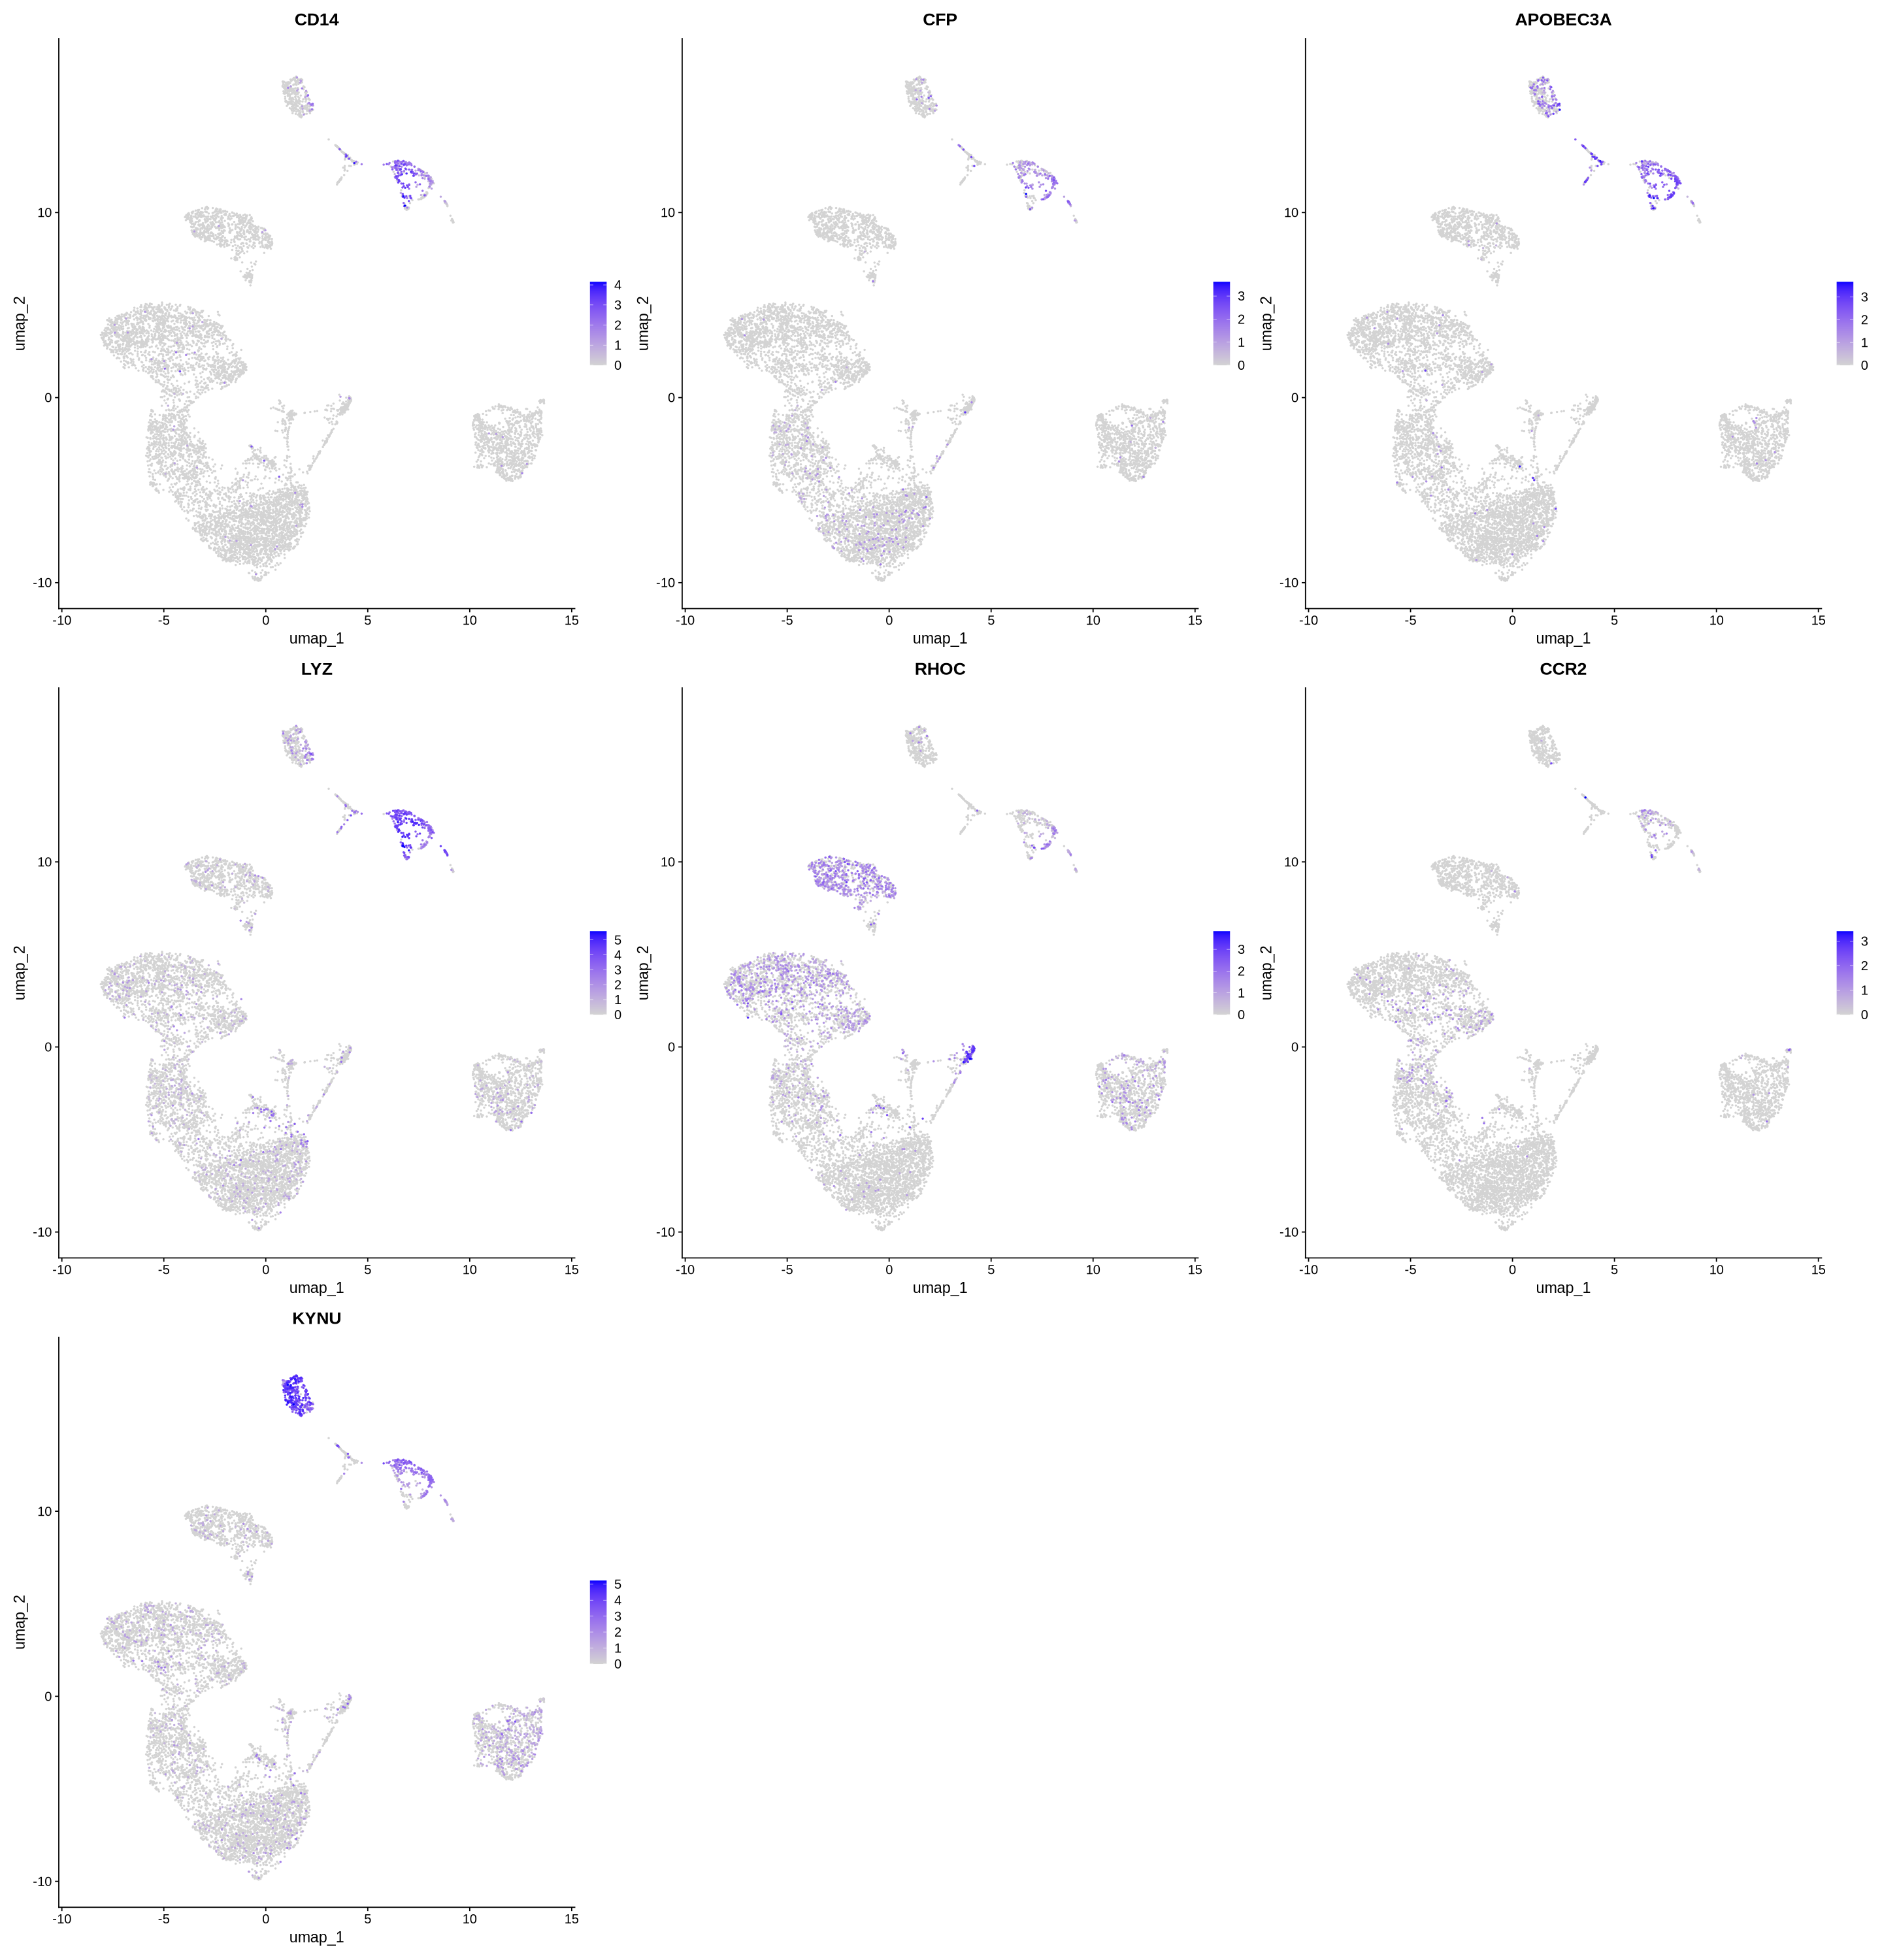

In [67]:
# воможно это моноциты, проверим
monocyte_markers <- c("CD14", "CFP", "APOBEC3A", "LYZ", "RHOC", "CCR2", "KYNU")
available_monocyte <- monocyte_markers[monocyte_markers %in% rownames(pbmc)]
options(repr.plot.width = 24, repr.plot.height = 25)
FeaturePlot(pbmc, features = available_monocyte, ncol = 3, order = TRUE)

На моноциты не похоже, провела ресёрч на сайте https://panglaodb.se/, но точный тип клеток опрелить не получилось

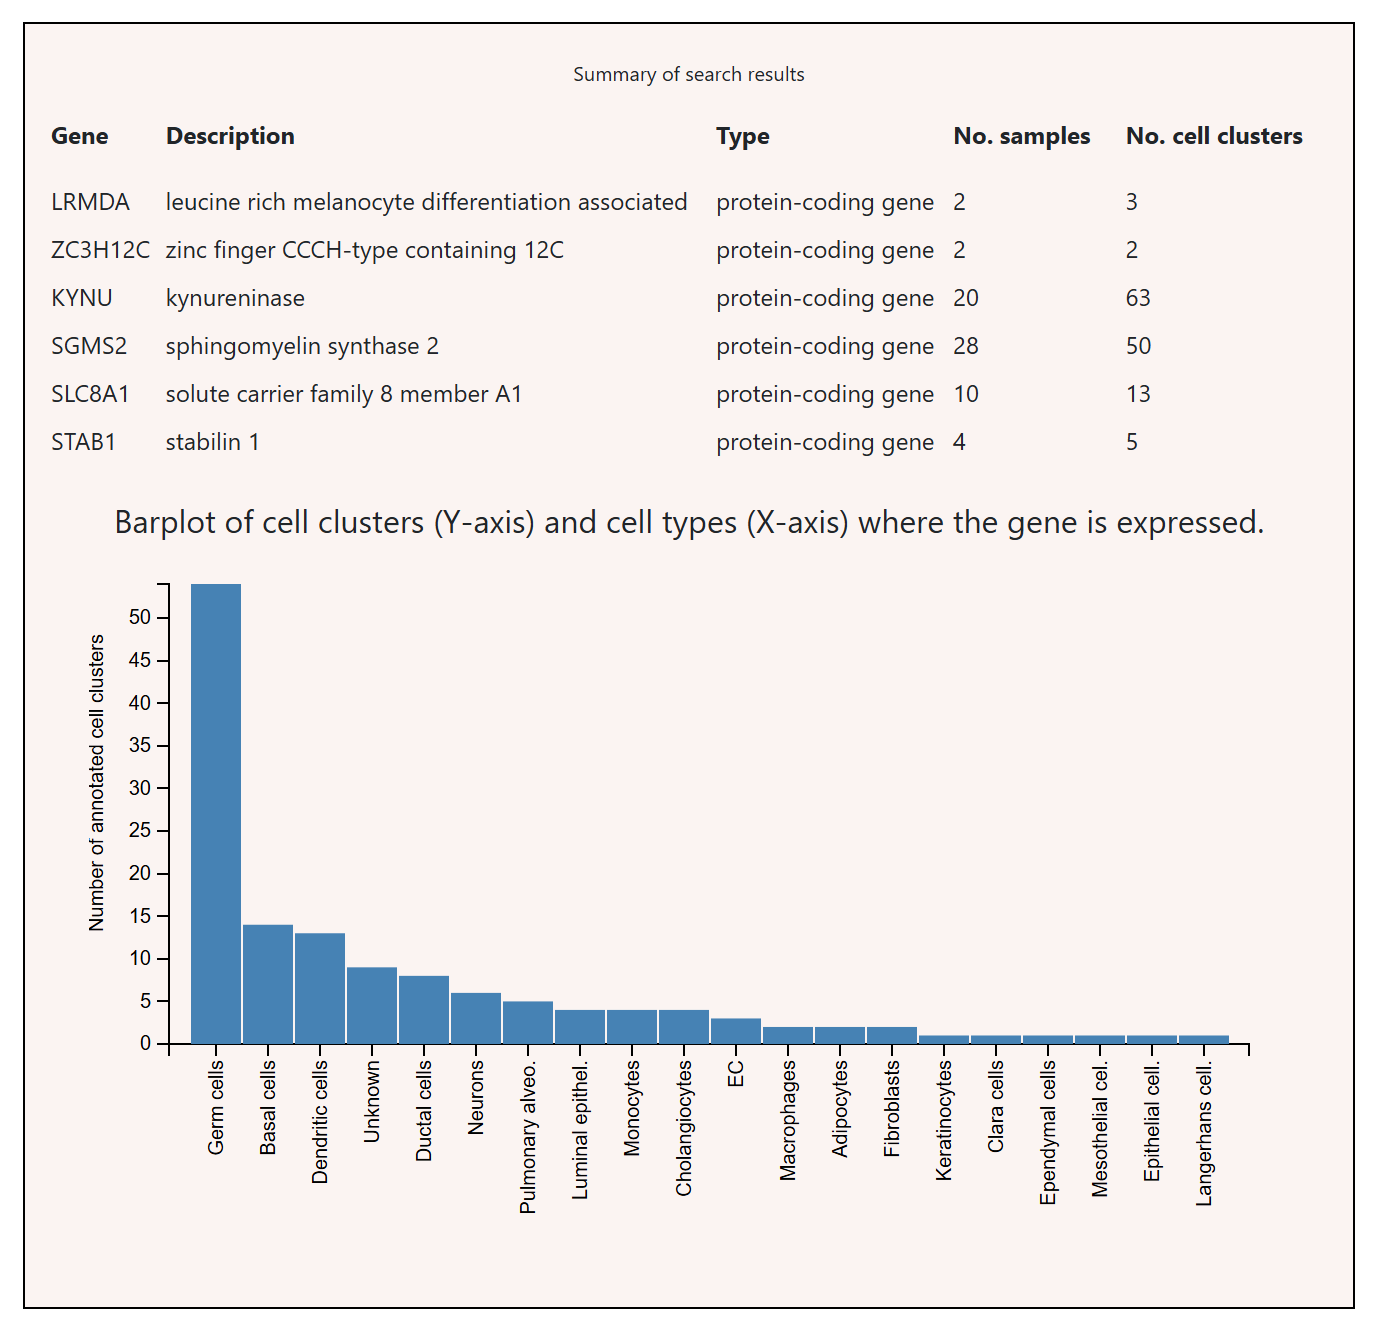

Вернёмся к итоговой кластеризации:

[1] "Таблица распределения:"

   Naive CD4+ T         Unknown   Memory CD4+ T         B cells        NK cells 
           2145            2174            1075             993             708 
         CD8+ T      CD14+ Mono Dendritic cells 
            893             269              56 


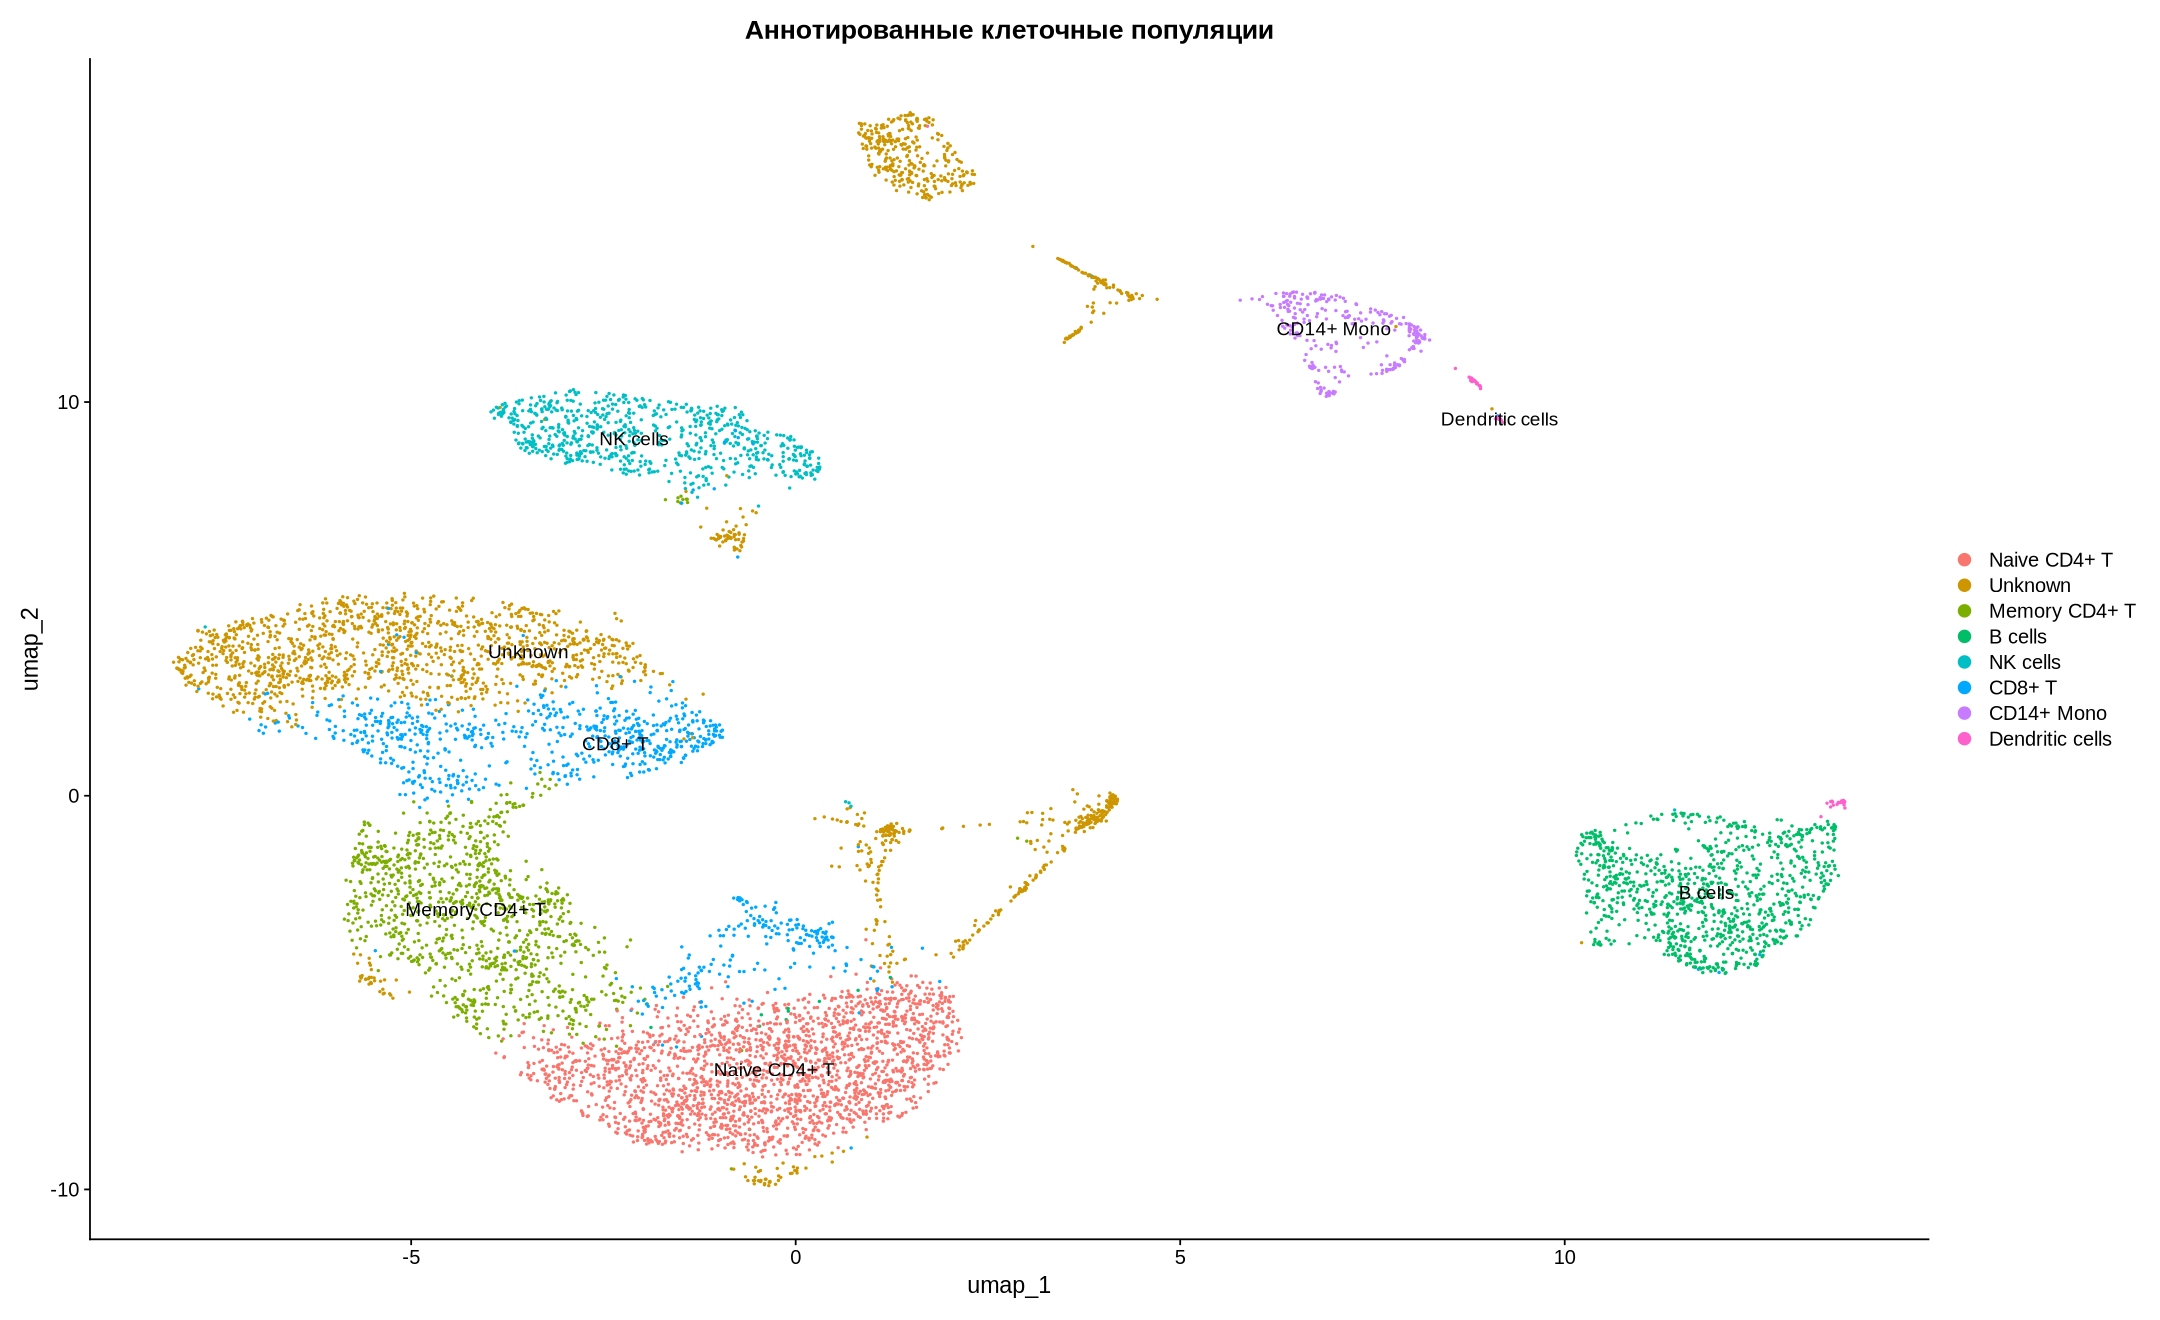

In [69]:

cell_type_factor <- factor(pbmc$seurat_clusters, 
                          levels = c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13"),
                          labels = c("Naive CD4+ T", "Unknown", "Memory CD4+ T", "B cells", 
                                    "NK cells", "CD8+ T", "CD8+ T", "Unknown", "CD14+ Mono",
                                    "Unknown", "Unknown", "Unknown", "Unknown", "Dendritic cells"))

# Добавляем в метаданные
pbmc$cell_type <- cell_type_factor

# Проверяем
print("Таблица распределения:")
print(table(pbmc$cell_type))

# Визуализация
options(repr.plot.width = 18, repr.plot.height = 11)
DimPlot(pbmc, reduction = "umap", group.by = "cell_type", label = TRUE) +
  ggtitle("Аннотированные клеточные популяции")

# Выводы:
С помощью библиотеки Seurat анализировала данные single-cell секвенирования, характеризующие экспрессию мононуклеарных клеток. Получили довольно хорошую кластеризацию клеточных типов, удалось выделить: B-клетки, CD8+, Naive CD4+, Memory CD4+, NK, CD14+ Mono и дендритные клетки. Так же остался неопределённым кластер 1, так как здесь есть как экспрессия генов, характерных для NK-клеток, так и маркёров T-клеток (CD3E). Отлично отделился кластер 7, но чёткой аннотации по топ-экспрессируемым генам найти не удалось, по данным panglaodb это могут быть моноциты или половые клетки, которых в образце быть не должно.